In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
LATENT_DIM = 64
NUM_GENERATORS = 3

In [3]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [4]:
X_train, X_test, Y_train, Y_test = data.get_dataset_augmented()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")

In [5]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [6]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentOracle().to(device)

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_entropy = nn.CrossEntropyLoss()

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.type(torch.LongTensor).to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_entropy(m_S,torch.argmax(torch.softmax(m,-1), -1))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_entropy(m.squeeze(),M)
        
        loss_S = loss1 + loss2 + loss3
        # loss_Ae = loss5
        loss_Ae = loss5 + loss1 # Testing ...
        loss_O = loss6
        
        loss_S.backward(retain_graph=True)
        loss_Ae.backward(retain_graph=True)
        loss_O.backward(retain_graph=True)
        
        
        
        optimiser_fd.step()
        optimiser_fe.step()
        optimiser_fo.step()
        optimiser_symmetry.step()
    
        
        loss_S_closure_ += loss1.item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss6.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 166/166 [00:03<00:00, 48.04it/s]


EPOCH 0 complete
Symmetry Closure Loss  0.09498300836477654
Symmetry Orthogonality Loss  0.0023385765720355177
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.06192563559456044
Oracle loss 0.2479728065341352


100%|██████████| 166/166 [00:03<00:00, 52.76it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.06220651945346091
Symmetry Orthogonality Loss  0.0008227727943975255
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.03427188402513064
Oracle loss 0.22601242399359323


100%|██████████| 166/166 [00:03<00:00, 53.92it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.05859876325331539
Symmetry Orthogonality Loss  0.0008141460975054203
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.023517237740557594
Oracle loss 0.20515561202563434


100%|██████████| 166/166 [00:03<00:00, 53.26it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.05684662702302617
Symmetry Orthogonality Loss  0.0008103327803925263
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.014539706144840962
Oracle loss 0.18391052157763976


100%|██████████| 166/166 [00:03<00:00, 53.42it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.06013939906674695
Symmetry Orthogonality Loss  0.0008068655130834913
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.01304427668990859
Oracle loss 0.1710293429443635


100%|██████████| 166/166 [00:03<00:00, 52.57it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.05190087996243713
Symmetry Orthogonality Loss  0.0008051126307516123
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.012685048595878733
Oracle loss 0.1623272918254496


100%|██████████| 166/166 [00:03<00:00, 51.00it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.04433153686394174
Symmetry Orthogonality Loss  0.000808505241826446
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.012034458080194441
Oracle loss 0.15273182749389166


100%|██████████| 166/166 [00:03<00:00, 54.61it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.043153042467423235
Symmetry Orthogonality Loss  0.000798862913471972
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.012431540459125158
Oracle loss 0.14818822843841759


100%|██████████| 166/166 [00:03<00:00, 53.23it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.038860691038061335
Symmetry Orthogonality Loss  0.0007834219985994993
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.01119792444003095
Oracle loss 0.14188161420534892


100%|██████████| 166/166 [00:03<00:00, 51.39it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.036525371203939595
Symmetry Orthogonality Loss  0.0007917261689463742
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.01094356296494244
Oracle loss 0.13782793337322144


100%|██████████| 166/166 [00:03<00:00, 51.28it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.034419744320393325
Symmetry Orthogonality Loss  0.0007695943269323198
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.01012766636145043
Oracle loss 0.13387249643544116


100%|██████████| 166/166 [00:03<00:00, 51.52it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.03160127818988389
Symmetry Orthogonality Loss  0.0007569779111044369
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00955828615879438
Oracle loss 0.1294342046491353


100%|██████████| 166/166 [00:03<00:00, 51.79it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.03337130580007671
Symmetry Orthogonality Loss  0.0007470723393047789
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.009987134587423629
Oracle loss 0.1270257744893252


100%|██████████| 166/166 [00:03<00:00, 53.15it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.030484207917049706
Symmetry Orthogonality Loss  0.0007272640552444676
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.009105686412518283
Oracle loss 0.12337516701544624


100%|██████████| 166/166 [00:03<00:00, 51.33it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.03025920533137508
Symmetry Orthogonality Loss  0.000756527503029477
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.008887518138389092
Oracle loss 0.12148970998374813


100%|██████████| 166/166 [00:03<00:00, 53.81it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.0271481769944889
Symmetry Orthogonality Loss  0.0007465834440439042
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007900529636451638
Oracle loss 0.11829186217432999


100%|██████████| 166/166 [00:03<00:00, 52.89it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.028340916586927622
Symmetry Orthogonality Loss  0.0007319598530940935
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007764976224805935
Oracle loss 0.117115109306143


100%|██████████| 166/166 [00:03<00:00, 51.10it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.027048735946686154
Symmetry Orthogonality Loss  0.0007174519372470004
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.007509005432724055
Oracle loss 0.1152217040309705


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.024467522817024266
Symmetry Orthogonality Loss  0.0007240382340141987
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006506224687446852
Oracle loss 0.1125979118767273


100%|██████████| 166/166 [00:03<00:00, 49.89it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.024741828250867057
Symmetry Orthogonality Loss  0.0007244005567164172
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006386648156646505
Oracle loss 0.11150815225688808


100%|██████████| 166/166 [00:03<00:00, 51.70it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.025837584600660456
Symmetry Orthogonality Loss  0.0007172284822445363
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006591888862740563
Oracle loss 0.11082886213279632


100%|██████████| 166/166 [00:03<00:00, 53.10it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.025362270401723414
Symmetry Orthogonality Loss  0.0007203793519945165
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00651202532631087
Oracle loss 0.10959933738572052


100%|██████████| 166/166 [00:03<00:00, 53.97it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.022508275740028144
Symmetry Orthogonality Loss  0.0007099477337190814
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005713507530268237
Oracle loss 0.10753389569111617


100%|██████████| 166/166 [00:03<00:00, 49.61it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.021523273931479597
Symmetry Orthogonality Loss  0.0006883608910861055
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005339728637475027
Oracle loss 0.10647851807704892


100%|██████████| 166/166 [00:03<00:00, 51.14it/s]


EPOCH 24 complete
Symmetry Closure Loss  0.02601864786975714
Symmetry Orthogonality Loss  0.0007047899451712707
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0068573409085532265
Oracle loss 0.10818645699196551


100%|██████████| 166/166 [00:03<00:00, 48.99it/s]


EPOCH 25 complete
Symmetry Closure Loss  0.02145986717912447
Symmetry Orthogonality Loss  0.0006897094247845866
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.006252744731616722
Oracle loss 0.10555467736649227


100%|██████████| 166/166 [00:03<00:00, 50.51it/s]


EPOCH 26 complete
Symmetry Closure Loss  0.01916225627064705
Symmetry Orthogonality Loss  0.0006808729916642679
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004987484977457179
Oracle loss 0.10400707184909339


100%|██████████| 166/166 [00:03<00:00, 50.41it/s]


EPOCH 27 complete
Symmetry Closure Loss  0.020552682196609228
Symmetry Orthogonality Loss  0.0006944499811696181
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0053839162973889024
Oracle loss 0.10424263797790172


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 28 complete
Symmetry Closure Loss  0.020113642103072392
Symmetry Orthogonality Loss  0.0006762826078885561
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005307973581310137
Oracle loss 0.10365991155246654


100%|██████████| 166/166 [00:03<00:00, 52.84it/s]


EPOCH 29 complete
Symmetry Closure Loss  0.020528170437249076
Symmetry Orthogonality Loss  0.0006830281520497996
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0059415381457881035
Oracle loss 0.10361087955085628


100%|██████████| 166/166 [00:03<00:00, 51.29it/s]


EPOCH 30 complete
Symmetry Closure Loss  0.017741320374231023
Symmetry Orthogonality Loss  0.0006677807033123696
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005070907756663769
Oracle loss 0.10214319771312806


100%|██████████| 166/166 [00:03<00:00, 51.68it/s]


EPOCH 31 complete
Symmetry Closure Loss  0.018103033607174832
Symmetry Orthogonality Loss  0.000670289303770805
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004655966624976641
Oracle loss 0.10182837836713676


100%|██████████| 166/166 [00:03<00:00, 48.13it/s]


EPOCH 32 complete
Symmetry Closure Loss  0.019848604910973323
Symmetry Orthogonality Loss  0.0006508317717115384
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004678010351462178
Oracle loss 0.10207746810762279


100%|██████████| 166/166 [00:03<00:00, 54.16it/s]


EPOCH 33 complete
Symmetry Closure Loss  0.021368877064571322
Symmetry Orthogonality Loss  0.0006666743864181889
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005426532499133104
Oracle loss 0.10251397356750017


100%|██████████| 166/166 [00:03<00:00, 51.48it/s]


EPOCH 34 complete
Symmetry Closure Loss  0.02018318731472435
Symmetry Orthogonality Loss  0.0006539028548882399
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0053322644685451165
Oracle loss 0.10176045748304172


100%|██████████| 166/166 [00:03<00:00, 50.81it/s]


EPOCH 35 complete
Symmetry Closure Loss  0.018308149572147662
Symmetry Orthogonality Loss  0.0006458785950138895
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004890515645741519
Oracle loss 0.10062107811850238


100%|██████████| 166/166 [00:03<00:00, 52.53it/s]


EPOCH 36 complete
Symmetry Closure Loss  0.019173033916986132
Symmetry Orthogonality Loss  0.0006406164047145566
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005156871512060963
Oracle loss 0.10079950870699193


100%|██████████| 166/166 [00:03<00:00, 48.25it/s]


EPOCH 37 complete
Symmetry Closure Loss  0.017692922002983738
Symmetry Orthogonality Loss  0.0006537118485528437
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.005110423386388694
Oracle loss 0.1000524430748928


100%|██████████| 166/166 [00:03<00:00, 50.25it/s]


EPOCH 38 complete
Symmetry Closure Loss  0.01581694075209369
Symmetry Orthogonality Loss  0.000655159897364519
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0040560453984302925
Oracle loss 0.09904684862458563


100%|██████████| 166/166 [00:03<00:00, 51.37it/s]


EPOCH 39 complete
Symmetry Closure Loss  0.017581364353108836
Symmetry Orthogonality Loss  0.0006430821082307901
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004388515972139606
Oracle loss 0.09931530749582383


100%|██████████| 166/166 [00:03<00:00, 49.82it/s]


EPOCH 40 complete
Symmetry Closure Loss  0.020252798594175333
Symmetry Orthogonality Loss  0.0006365760293345988
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004832877721413073
Oracle loss 0.10007073855902775


100%|██████████| 166/166 [00:03<00:00, 50.42it/s]


EPOCH 41 complete
Symmetry Closure Loss  0.018958317160785915
Symmetry Orthogonality Loss  0.000635434611116996
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004846269046012537
Oracle loss 0.09953957253012312


100%|██████████| 166/166 [00:03<00:00, 51.86it/s]


EPOCH 42 complete
Symmetry Closure Loss  0.019842888755970692
Symmetry Orthogonality Loss  0.0006410372531159321
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004581363072214895
Oracle loss 0.09935131722904113


100%|██████████| 166/166 [00:03<00:00, 48.86it/s]


EPOCH 43 complete
Symmetry Closure Loss  0.01858693288347448
Symmetry Orthogonality Loss  0.0006462207925926715
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004593365598492414
Oracle loss 0.09893076144248607


100%|██████████| 166/166 [00:03<00:00, 51.08it/s]


EPOCH 44 complete
Symmetry Closure Loss  0.0178191561970007
Symmetry Orthogonality Loss  0.0006353050145651607
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0042685591615736485
Oracle loss 0.09836173389690468


100%|██████████| 166/166 [00:03<00:00, 50.58it/s]


EPOCH 45 complete
Symmetry Closure Loss  0.0179668639853866
Symmetry Orthogonality Loss  0.0006312243303800203
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004274872274710292
Oracle loss 0.09826595161155045


100%|██████████| 166/166 [00:03<00:00, 53.17it/s]


EPOCH 46 complete
Symmetry Closure Loss  0.018246325305158115
Symmetry Orthogonality Loss  0.0006280626778361803
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004084761335839887
Oracle loss 0.09809967516416526


100%|██████████| 166/166 [00:03<00:00, 50.51it/s]


EPOCH 47 complete
Symmetry Closure Loss  0.018473253663943475
Symmetry Orthogonality Loss  0.0006404142435471786
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0041771400860140485
Oracle loss 0.09798595529184284


100%|██████████| 166/166 [00:03<00:00, 49.66it/s]


EPOCH 48 complete
Symmetry Closure Loss  0.017675478796822477
Symmetry Orthogonality Loss  0.0006190999386501106
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004090203827875386
Oracle loss 0.09747536107897758


100%|██████████| 166/166 [00:03<00:00, 50.70it/s]


EPOCH 49 complete
Symmetry Closure Loss  0.016854560372969472
Symmetry Orthogonality Loss  0.0006276916197770421
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0038030730667019106
Oracle loss 0.09707879818168032


100%|██████████| 166/166 [00:03<00:00, 50.94it/s]


EPOCH 50 complete
Symmetry Closure Loss  0.01894227084872055
Symmetry Orthogonality Loss  0.0006266662494015757
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004023632559229631
Oracle loss 0.09773592830422413


100%|██████████| 166/166 [00:03<00:00, 50.73it/s]


EPOCH 51 complete
Symmetry Closure Loss  0.020061944476721518
Symmetry Orthogonality Loss  0.000636750706667866
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004504875610975257
Oracle loss 0.09808373096657086


100%|██████████| 166/166 [00:03<00:00, 50.66it/s]


EPOCH 52 complete
Symmetry Closure Loss  0.01648119054959122
Symmetry Orthogonality Loss  0.0006169451345235154
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003949997325270739
Oracle loss 0.0966319562081831


100%|██████████| 166/166 [00:03<00:00, 52.01it/s]


EPOCH 53 complete
Symmetry Closure Loss  0.01685863058924316
Symmetry Orthogonality Loss  0.0006069588714772947
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0038936055975079716
Oracle loss 0.09664900376495109


100%|██████████| 166/166 [00:03<00:00, 52.19it/s]


EPOCH 54 complete
Symmetry Closure Loss  0.020189289026052118
Symmetry Orthogonality Loss  0.0006297532972565526
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004397533640422556
Oracle loss 0.09761113098945963


100%|██████████| 166/166 [00:03<00:00, 50.99it/s]


EPOCH 55 complete
Symmetry Closure Loss  0.017001253491020704
Symmetry Orthogonality Loss  0.0006303180104503071
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003954945864290537
Oracle loss 0.09640316692102387


100%|██████████| 166/166 [00:03<00:00, 51.10it/s]


EPOCH 56 complete
Symmetry Closure Loss  0.015102843327604863
Symmetry Orthogonality Loss  0.0006106355433010059
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003425051155219595
Oracle loss 0.09567533765571663


100%|██████████| 166/166 [00:03<00:00, 49.59it/s]


EPOCH 57 complete
Symmetry Closure Loss  0.01848719384049974
Symmetry Orthogonality Loss  0.0006094782298335424
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003903396925552333
Oracle loss 0.09642589092254639


100%|██████████| 166/166 [00:03<00:00, 51.02it/s]


EPOCH 58 complete
Symmetry Closure Loss  0.017084883082747818
Symmetry Orthogonality Loss  0.0006240186921786517
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004058542105941528
Oracle loss 0.09616528981062303


100%|██████████| 166/166 [00:03<00:00, 50.87it/s]


EPOCH 59 complete
Symmetry Closure Loss  0.016116724590804564
Symmetry Orthogonality Loss  0.0006133054007203823
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004072031317592924
Oracle loss 0.0957710707492857


100%|██████████| 166/166 [00:03<00:00, 51.70it/s]


EPOCH 60 complete
Symmetry Closure Loss  0.016107914638312824
Symmetry Orthogonality Loss  0.0005899215333096413
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003590665631422616
Oracle loss 0.09552774133991046


100%|██████████| 166/166 [00:03<00:00, 53.19it/s]


EPOCH 61 complete
Symmetry Closure Loss  0.01766010142122227
Symmetry Orthogonality Loss  0.0006040064435654197
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003909838772996004
Oracle loss 0.0959684333977211


100%|██████████| 166/166 [00:03<00:00, 51.50it/s]


EPOCH 62 complete
Symmetry Closure Loss  0.0158409936275019
Symmetry Orthogonality Loss  0.0006164000341556517
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003604835272396365
Oracle loss 0.09521243577621069


100%|██████████| 166/166 [00:03<00:00, 50.90it/s]


EPOCH 63 complete
Symmetry Closure Loss  0.01640303135591458
Symmetry Orthogonality Loss  0.000596137825365975
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0035158776431288346
Oracle loss 0.09518337721027524


100%|██████████| 166/166 [00:03<00:00, 51.66it/s]


EPOCH 64 complete
Symmetry Closure Loss  0.01836403755538435
Symmetry Orthogonality Loss  0.0005911555367729526
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003927077668864864
Oracle loss 0.09588440328118313


100%|██████████| 166/166 [00:03<00:00, 51.53it/s]


EPOCH 65 complete
Symmetry Closure Loss  0.018808840706675167
Symmetry Orthogonality Loss  0.0005930591920244856
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003699764232039003
Oracle loss 0.09581848736627992


100%|██████████| 166/166 [00:03<00:00, 50.83it/s]


EPOCH 66 complete
Symmetry Closure Loss  0.01643638311133507
Symmetry Orthogonality Loss  0.0005973625015775976
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0037129593533407673
Oracle loss 0.09500946284058583


100%|██████████| 166/166 [00:03<00:00, 52.41it/s]


EPOCH 67 complete
Symmetry Closure Loss  0.014569286285080465
Symmetry Orthogonality Loss  0.000602226865657392
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033052879924246347
Oracle loss 0.09413561054381979


100%|██████████| 166/166 [00:03<00:00, 51.21it/s]


EPOCH 68 complete
Symmetry Closure Loss  0.014973458317837801
Symmetry Orthogonality Loss  0.0005894677530474826
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003122604499761778
Oracle loss 0.09416822532573378


100%|██████████| 166/166 [00:03<00:00, 49.91it/s]


EPOCH 69 complete
Symmetry Closure Loss  0.015508618065526327
Symmetry Orthogonality Loss  0.0005870611071642712
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0034307439668463118
Oracle loss 0.09437571869916227


100%|██████████| 166/166 [00:03<00:00, 51.92it/s]


EPOCH 70 complete
Symmetry Closure Loss  0.016438410493982845
Symmetry Orthogonality Loss  0.0005907677766216178
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003567629568110478
Oracle loss 0.09460084952683334


100%|██████████| 166/166 [00:03<00:00, 50.68it/s]


EPOCH 71 complete
Symmetry Closure Loss  0.016638291399387353
Symmetry Orthogonality Loss  0.0005810498070611382
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003602237631398511
Oracle loss 0.09456351583442056


100%|██████████| 166/166 [00:03<00:00, 50.96it/s]


EPOCH 72 complete
Symmetry Closure Loss  0.015368425298527062
Symmetry Orthogonality Loss  0.0005865623471074659
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003119342347483588
Oracle loss 0.09400068174105093


100%|██████████| 166/166 [00:03<00:00, 51.35it/s]


EPOCH 73 complete
Symmetry Closure Loss  0.014650544550000545
Symmetry Orthogonality Loss  0.0005645746917811682
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028626157043793476
Oracle loss 0.09375840649906411


100%|██████████| 166/166 [00:03<00:00, 51.49it/s]


EPOCH 74 complete
Symmetry Closure Loss  0.01530305728181658
Symmetry Orthogonality Loss  0.0005798083621340927
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003300653931864324
Oracle loss 0.09393738466034453


100%|██████████| 166/166 [00:03<00:00, 51.74it/s]


EPOCH 75 complete
Symmetry Closure Loss  0.01638530434322465
Symmetry Orthogonality Loss  0.0005797896206698729
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0036317688631769046
Oracle loss 0.09437551914927471


100%|██████████| 166/166 [00:03<00:00, 50.40it/s]


EPOCH 76 complete
Symmetry Closure Loss  0.015332160966403514
Symmetry Orthogonality Loss  0.0005769380491019327
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003170960512663047
Oracle loss 0.093743102916752


100%|██████████| 166/166 [00:03<00:00, 50.90it/s]


EPOCH 77 complete
Symmetry Closure Loss  0.015138967046850776
Symmetry Orthogonality Loss  0.0005641959583757064
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030429926224008023
Oracle loss 0.09358843079352953


100%|██████████| 166/166 [00:03<00:00, 50.55it/s]


EPOCH 78 complete
Symmetry Closure Loss  0.014952322855277592
Symmetry Orthogonality Loss  0.0005721677892774074
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003330072386650346
Oracle loss 0.09367608898375408


100%|██████████| 166/166 [00:03<00:00, 52.30it/s]


EPOCH 79 complete
Symmetry Closure Loss  0.015408406421227986
Symmetry Orthogonality Loss  0.0005791859111484948
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003118140381727233
Oracle loss 0.09365409904395242


100%|██████████| 166/166 [00:03<00:00, 48.24it/s]


EPOCH 80 complete
Symmetry Closure Loss  0.015616885077836642
Symmetry Orthogonality Loss  0.0005682266586606043
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0035419327176052584
Oracle loss 0.09379220910998712


100%|██████████| 166/166 [00:03<00:00, 50.24it/s]


EPOCH 81 complete
Symmetry Closure Loss  0.014608328808547861
Symmetry Orthogonality Loss  0.0005699017813432042
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003028941149991679
Oracle loss 0.093267674815942


100%|██████████| 166/166 [00:03<00:00, 48.68it/s]


EPOCH 82 complete
Symmetry Closure Loss  0.014838964352945247
Symmetry Orthogonality Loss  0.0005689017682936581
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003097945278656321
Oracle loss 0.09325919533709445


100%|██████████| 166/166 [00:03<00:00, 52.41it/s]


EPOCH 83 complete
Symmetry Closure Loss  0.014478461917893714
Symmetry Orthogonality Loss  0.0005710025869186474
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030569373966609858
Oracle loss 0.09321665539439902


100%|██████████| 166/166 [00:03<00:00, 51.83it/s]


EPOCH 84 complete
Symmetry Closure Loss  0.01482070182977491
Symmetry Orthogonality Loss  0.0005820157835316137
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033040018317413078
Oracle loss 0.09345656777002725


100%|██████████| 166/166 [00:03<00:00, 51.73it/s]


EPOCH 85 complete
Symmetry Closure Loss  0.014551992124193404
Symmetry Orthogonality Loss  0.0005577684419386717
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003302125242000154
Oracle loss 0.09332868497235229


100%|██████████| 166/166 [00:03<00:00, 49.49it/s]


EPOCH 86 complete
Symmetry Closure Loss  0.01479085517979889
Symmetry Orthogonality Loss  0.0005536629707574934
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003106062600658421
Oracle loss 0.09330725427492555


100%|██████████| 166/166 [00:03<00:00, 50.36it/s]


EPOCH 87 complete
Symmetry Closure Loss  0.014762467379311481
Symmetry Orthogonality Loss  0.0005569308235293187
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030303038221907363
Oracle loss 0.09328432681869311


100%|██████████| 166/166 [00:03<00:00, 50.46it/s]


EPOCH 88 complete
Symmetry Closure Loss  0.014097102154719543
Symmetry Orthogonality Loss  0.0005505106005823262
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027952664615923024
Oracle loss 0.09303769603910217


100%|██████████| 166/166 [00:03<00:00, 51.50it/s]


EPOCH 89 complete
Symmetry Closure Loss  0.014746321735522115
Symmetry Orthogonality Loss  0.0005442130516833031
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003038681016853416
Oracle loss 0.09323658722351832


100%|██████████| 166/166 [00:03<00:00, 52.53it/s]


EPOCH 90 complete
Symmetry Closure Loss  0.014703639480004827
Symmetry Orthogonality Loss  0.000545053663930059
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0029696580218936666
Oracle loss 0.09314481501119683


100%|██████████| 166/166 [00:03<00:00, 49.48it/s]


EPOCH 91 complete
Symmetry Closure Loss  0.01406036566449217
Symmetry Orthogonality Loss  0.0005408619417940794
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002726028967895601
Oracle loss 0.09299899152962558


100%|██████████| 166/166 [00:03<00:00, 51.13it/s]


EPOCH 92 complete
Symmetry Closure Loss  0.014900710888162076
Symmetry Orthogonality Loss  0.0005355472807949185
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028782566204240702
Oracle loss 0.09321068501077502


100%|██████████| 166/166 [00:03<00:00, 49.57it/s]


EPOCH 93 complete
Symmetry Closure Loss  0.014174247373748257
Symmetry Orthogonality Loss  0.000546005516276549
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027855139054604864
Oracle loss 0.09291022612028811


100%|██████████| 166/166 [00:03<00:00, 51.36it/s]


EPOCH 94 complete
Symmetry Closure Loss  0.013511843059256852
Symmetry Orthogonality Loss  0.0005367786116149075
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025027708503900163
Oracle loss 0.09268010542335281


100%|██████████| 166/166 [00:03<00:00, 51.81it/s]


EPOCH 95 complete
Symmetry Closure Loss  0.015523985909096089
Symmetry Orthogonality Loss  0.0005392338651027642
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030775077021063632
Oracle loss 0.09334460497800126


100%|██████████| 166/166 [00:03<00:00, 52.22it/s]


EPOCH 96 complete
Symmetry Closure Loss  0.014015247276703635
Symmetry Orthogonality Loss  0.0005272931015365813
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025236082167914473
Oracle loss 0.09284013765583556


100%|██████████| 166/166 [00:03<00:00, 50.50it/s]


EPOCH 97 complete
Symmetry Closure Loss  0.013975569804434675
Symmetry Orthogonality Loss  0.0005350831094133409
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002725071101225015
Oracle loss 0.09277399270290351


100%|██████████| 166/166 [00:03<00:00, 51.66it/s]


EPOCH 98 complete
Symmetry Closure Loss  0.013020146245428597
Symmetry Orthogonality Loss  0.0005303415901473645
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024494153548435993
Oracle loss 0.0924627913768033


100%|██████████| 166/166 [00:03<00:00, 51.99it/s]


EPOCH 99 complete
Symmetry Closure Loss  0.013190489026706621
Symmetry Orthogonality Loss  0.0005251397648742086
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023882732143154345
Oracle loss 0.092434949724071


100%|██████████| 166/166 [00:03<00:00, 50.08it/s]


EPOCH 100 complete
Symmetry Closure Loss  0.013062196026320558
Symmetry Orthogonality Loss  0.0005207103855924748
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002413987946494606
Oracle loss 0.0923905206552471


100%|██████████| 166/166 [00:03<00:00, 51.20it/s]


EPOCH 101 complete
Symmetry Closure Loss  0.01437648634863905
Symmetry Orthogonality Loss  0.0005224552447346589
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002878383649176503
Oracle loss 0.09279627011842038


100%|██████████| 166/166 [00:03<00:00, 50.67it/s]


EPOCH 102 complete
Symmetry Closure Loss  0.014231316116919001
Symmetry Orthogonality Loss  0.0005160833222241735
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002808127379751798
Oracle loss 0.09277418439826333


100%|██████████| 166/166 [00:03<00:00, 49.33it/s]


EPOCH 103 complete
Symmetry Closure Loss  0.013962549836296275
Symmetry Orthogonality Loss  0.0005160801853221583
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025379499546757125
Oracle loss 0.09275296263127442


100%|██████████| 166/166 [00:03<00:00, 50.30it/s]


EPOCH 104 complete
Symmetry Closure Loss  0.014472267248230168
Symmetry Orthogonality Loss  0.0005230292876346418
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002885626565878201
Oracle loss 0.09287209714572113


100%|██████████| 166/166 [00:03<00:00, 49.46it/s]


EPOCH 105 complete
Symmetry Closure Loss  0.013887562648763499
Symmetry Orthogonality Loss  0.0005198689885942422
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002494343018568828
Oracle loss 0.09257173524743104


100%|██████████| 166/166 [00:03<00:00, 51.32it/s]


EPOCH 106 complete
Symmetry Closure Loss  0.012851187347782305
Symmetry Orthogonality Loss  0.000505643676025288
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023084558800412678
Oracle loss 0.09231126039143069


100%|██████████| 166/166 [00:03<00:00, 51.35it/s]


EPOCH 107 complete
Symmetry Closure Loss  0.01431602823087968
Symmetry Orthogonality Loss  0.000509756922136981
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002891812218263386
Oracle loss 0.09276710612228117


100%|██████████| 166/166 [00:03<00:00, 50.13it/s]


EPOCH 108 complete
Symmetry Closure Loss  0.013411549666155893
Symmetry Orthogonality Loss  0.0005022694028181821
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022807702294505953
Oracle loss 0.09235170645168028


100%|██████████| 166/166 [00:03<00:00, 49.89it/s]


EPOCH 109 complete
Symmetry Closure Loss  0.012856021714228463
Symmetry Orthogonality Loss  0.0005091139047367342
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022257410609780484
Oracle loss 0.09220720051103327


100%|██████████| 166/166 [00:03<00:00, 52.74it/s]


EPOCH 110 complete
Symmetry Closure Loss  0.012819990201527813
Symmetry Orthogonality Loss  0.0005051559240540422
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002176008453727307
Oracle loss 0.09225905879613865


100%|██████████| 166/166 [00:03<00:00, 50.84it/s]


EPOCH 111 complete
Symmetry Closure Loss  0.013938385763216809
Symmetry Orthogonality Loss  0.0005086163130409297
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002805050640613828
Oracle loss 0.09263118800808148


100%|██████████| 166/166 [00:03<00:00, 51.12it/s]


EPOCH 112 complete
Symmetry Closure Loss  0.013889246861484036
Symmetry Orthogonality Loss  0.0005117359664782051
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002616057248859027
Oracle loss 0.09254329790731511


100%|██████████| 166/166 [00:03<00:00, 50.36it/s]


EPOCH 113 complete
Symmetry Closure Loss  0.011989610123795917
Symmetry Orthogonality Loss  0.0004884983582635332
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020517432018665664
Oracle loss 0.09193347924085984


100%|██████████| 166/166 [00:03<00:00, 45.21it/s]


EPOCH 114 complete
Symmetry Closure Loss  0.012104814524302282
Symmetry Orthogonality Loss  0.0005015836071702708
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023349017502336078
Oracle loss 0.09205236362226038


100%|██████████| 166/166 [00:03<00:00, 50.44it/s]


EPOCH 115 complete
Symmetry Closure Loss  0.013451809501163212
Symmetry Orthogonality Loss  0.000486740013002418
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024653214684979296
Oracle loss 0.09232013533452907


100%|██████████| 166/166 [00:03<00:00, 50.46it/s]


EPOCH 116 complete
Symmetry Closure Loss  0.015319650274622872
Symmetry Orthogonality Loss  0.0004912915764760832
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003256284861814186
Oracle loss 0.09294596085526857


100%|██████████| 166/166 [00:03<00:00, 51.54it/s]


EPOCH 117 complete
Symmetry Closure Loss  0.01312564379053123
Symmetry Orthogonality Loss  0.0004785215169687879
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002326851298314441
Oracle loss 0.09212447824068816


100%|██████████| 166/166 [00:03<00:00, 52.09it/s]


EPOCH 118 complete
Symmetry Closure Loss  0.01378648580579334
Symmetry Orthogonality Loss  0.0004803466744558235
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026299177391275047
Oracle loss 0.0923857988722353


100%|██████████| 166/166 [00:03<00:00, 51.02it/s]


EPOCH 119 complete
Symmetry Closure Loss  0.013467027351305068
Symmetry Orthogonality Loss  0.00047953090881536073
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021835472119175435
Oracle loss 0.0921898230192173


100%|██████████| 166/166 [00:03<00:00, 50.67it/s]


EPOCH 120 complete
Symmetry Closure Loss  0.013033188963645553
Symmetry Orthogonality Loss  0.0004800332661757403
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002301779020218605
Oracle loss 0.09217842973499413


100%|██████████| 166/166 [00:03<00:00, 48.47it/s]


EPOCH 121 complete
Symmetry Closure Loss  0.013406325008226446
Symmetry Orthogonality Loss  0.00047256836176047615
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022239499502388917
Oracle loss 0.0921870286026633


100%|██████████| 166/166 [00:03<00:00, 51.34it/s]


EPOCH 122 complete
Symmetry Closure Loss  0.013384442366884056
Symmetry Orthogonality Loss  0.0004841673245067226
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002254729567331273
Oracle loss 0.09219880900289638


100%|██████████| 166/166 [00:03<00:00, 51.75it/s]


EPOCH 123 complete
Symmetry Closure Loss  0.012931742458548173
Symmetry Orthogonality Loss  0.0004768325897783647
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00227523079641298
Oracle loss 0.09218569602592881


100%|██████████| 166/166 [00:03<00:00, 50.95it/s]


EPOCH 124 complete
Symmetry Closure Loss  0.012488774091274623
Symmetry Orthogonality Loss  0.0004729830098186945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0019881146537779593
Oracle loss 0.09200481958238475


100%|██████████| 166/166 [00:03<00:00, 51.96it/s]


EPOCH 125 complete
Symmetry Closure Loss  0.011903346426425928
Symmetry Orthogonality Loss  0.00047036317960465754
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017775389708084874
Oracle loss 0.0918413324797728


100%|██████████| 166/166 [00:03<00:00, 51.37it/s]


EPOCH 126 complete
Symmetry Closure Loss  0.013200727426054248
Symmetry Orthogonality Loss  0.00047385341614759695
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021423331219198026
Oracle loss 0.09218958154859314


100%|██████████| 166/166 [00:03<00:00, 49.45it/s]


EPOCH 127 complete
Symmetry Closure Loss  0.013068543101874101
Symmetry Orthogonality Loss  0.0004744088448687872
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020370886952851912
Oracle loss 0.0920642600002059


100%|██████████| 166/166 [00:03<00:00, 50.42it/s]


EPOCH 128 complete
Symmetry Closure Loss  0.01567226118150066
Symmetry Orthogonality Loss  0.0004789123491521543
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003306016892598695
Oracle loss 0.09299248308841004


100%|██████████| 166/166 [00:03<00:00, 48.89it/s]


EPOCH 129 complete
Symmetry Closure Loss  0.016823149016912443
Symmetry Orthogonality Loss  0.000472556679202412
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004299996918662036
Oracle loss 0.09355555075299309


100%|██████████| 166/166 [00:03<00:00, 50.02it/s]


EPOCH 130 complete
Symmetry Closure Loss  0.013375415960438999
Symmetry Orthogonality Loss  0.00045628067374605324
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025033390279915408
Oracle loss 0.09213698220001645


100%|██████████| 166/166 [00:03<00:00, 50.12it/s]


EPOCH 131 complete
Symmetry Closure Loss  0.011582761795361
Symmetry Orthogonality Loss  0.00046744879723683625
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001625460337606225
Oracle loss 0.09157522660062974


100%|██████████| 166/166 [00:03<00:00, 50.75it/s]


EPOCH 132 complete
Symmetry Closure Loss  0.011556793991700712
Symmetry Orthogonality Loss  0.0004531619351508702
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016818123242638287
Oracle loss 0.09162739821406732


100%|██████████| 166/166 [00:03<00:00, 51.92it/s]


EPOCH 133 complete
Symmetry Closure Loss  0.012838019697691303
Symmetry Orthogonality Loss  0.0004618035181262811
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001986326181318566
Oracle loss 0.09195119501596474


100%|██████████| 166/166 [00:03<00:00, 50.90it/s]


EPOCH 134 complete
Symmetry Closure Loss  0.014092350036399552
Symmetry Orthogonality Loss  0.0004607947705964367
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022415782616709372
Oracle loss 0.09220197487128787


100%|██████████| 166/166 [00:03<00:00, 50.32it/s]


EPOCH 135 complete
Symmetry Closure Loss  0.013240110942622623
Symmetry Orthogonality Loss  0.00044584804998587323
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020705486215785683
Oracle loss 0.09210709154785397


100%|██████████| 166/166 [00:03<00:00, 49.92it/s]


EPOCH 136 complete
Symmetry Closure Loss  0.01213800683842007
Symmetry Orthogonality Loss  0.00044538705074649126
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018244434382306434
Oracle loss 0.09177842206624617


100%|██████████| 166/166 [00:03<00:00, 47.79it/s]


EPOCH 137 complete
Symmetry Closure Loss  0.01124493906229555
Symmetry Orthogonality Loss  0.00045002338193155016
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015502224104052566
Oracle loss 0.09156130739005215


100%|██████████| 166/166 [00:03<00:00, 51.49it/s]


EPOCH 138 complete
Symmetry Closure Loss  0.01288497279095183
Symmetry Orthogonality Loss  0.00046738680309745066
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017582581445844058
Oracle loss 0.09185511102697935


100%|██████████| 166/166 [00:03<00:00, 51.98it/s]


EPOCH 139 complete
Symmetry Closure Loss  0.015040122780455164
Symmetry Orthogonality Loss  0.00045734445469072424
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026828586839206785
Oracle loss 0.09251453476138861


100%|██████████| 166/166 [00:03<00:00, 51.35it/s]


EPOCH 140 complete
Symmetry Closure Loss  0.01586676796853363
Symmetry Orthogonality Loss  0.00044890484125325344
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0034874351765309653
Oracle loss 0.09286409751119384


100%|██████████| 166/166 [00:03<00:00, 49.87it/s]


EPOCH 141 complete
Symmetry Closure Loss  0.014331693351493183
Symmetry Orthogonality Loss  0.0004471539167676076
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003002428783507771
Oracle loss 0.0924856627741492


100%|██████████| 166/166 [00:03<00:00, 51.40it/s]


EPOCH 142 complete
Symmetry Closure Loss  0.012767246559666223
Symmetry Orthogonality Loss  0.0004475770499949983
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022867063974894315
Oracle loss 0.09198795963662217


100%|██████████| 166/166 [00:03<00:00, 52.47it/s]


EPOCH 143 complete
Symmetry Closure Loss  0.011635862504053547
Symmetry Orthogonality Loss  0.00043846634360372527
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017126202898896691
Oracle loss 0.09160298095589661


100%|██████████| 166/166 [00:03<00:00, 53.67it/s]


EPOCH 144 complete
Symmetry Closure Loss  0.014309377762971514
Symmetry Orthogonality Loss  0.0004427670374939061
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002351772682516869
Oracle loss 0.09229468020150461


100%|██████████| 166/166 [00:03<00:00, 52.49it/s]


EPOCH 145 complete
Symmetry Closure Loss  0.01239789382229189
Symmetry Orthogonality Loss  0.00044897931620214944
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018284447120884098
Oracle loss 0.09175918646246554


100%|██████████| 166/166 [00:03<00:00, 52.74it/s]


EPOCH 146 complete
Symmetry Closure Loss  0.01254092992272183
Symmetry Orthogonality Loss  0.00044100169907324016
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001925979531931141
Oracle loss 0.09182805666722448


100%|██████████| 166/166 [00:03<00:00, 51.90it/s]


EPOCH 147 complete
Symmetry Closure Loss  0.012362280686621565
Symmetry Orthogonality Loss  0.00044472183343527996
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0019415105841717269
Oracle loss 0.09184141896934395


100%|██████████| 166/166 [00:03<00:00, 52.38it/s]


EPOCH 148 complete
Symmetry Closure Loss  0.013010732363909483
Symmetry Orthogonality Loss  0.0004345905249629798
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00202327335522656
Oracle loss 0.09193869172988167


100%|██████████| 166/166 [00:03<00:00, 51.80it/s]


EPOCH 149 complete
Symmetry Closure Loss  0.012642458389816156
Symmetry Orthogonality Loss  0.0004410166575654735
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018783627745571983
Oracle loss 0.09177389480622418


100%|██████████| 166/166 [00:03<00:00, 50.59it/s]


EPOCH 150 complete
Symmetry Closure Loss  0.012917115504528025
Symmetry Orthogonality Loss  0.0004312468610959217
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002167471906826663
Oracle loss 0.0920514935201191


100%|██████████| 166/166 [00:03<00:00, 52.92it/s]


EPOCH 151 complete
Symmetry Closure Loss  0.014336271043193627
Symmetry Orthogonality Loss  0.0004301418212637956
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00319231419083494
Oracle loss 0.09246610899467066


100%|██████████| 166/166 [00:03<00:00, 53.66it/s]


EPOCH 152 complete
Symmetry Closure Loss  0.013634396413991967
Symmetry Orthogonality Loss  0.0004327456205269793
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028690534338063323
Oracle loss 0.09229417612035591


100%|██████████| 166/166 [00:03<00:00, 52.28it/s]


EPOCH 153 complete
Symmetry Closure Loss  0.011952800451811537
Symmetry Orthogonality Loss  0.000424607778220516
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017328402069565583
Oracle loss 0.09160893545093307


100%|██████████| 166/166 [00:03<00:00, 52.18it/s]


EPOCH 154 complete
Symmetry Closure Loss  0.010414027311581087
Symmetry Orthogonality Loss  0.0004225831353652616
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012891897588059396
Oracle loss 0.09128469646156552


100%|██████████| 166/166 [00:03<00:00, 52.44it/s]


EPOCH 155 complete
Symmetry Closure Loss  0.01132548980257777
Symmetry Orthogonality Loss  0.0004246974022391376
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014560860287151243
Oracle loss 0.09149935805653951


100%|██████████| 166/166 [00:03<00:00, 51.43it/s]


EPOCH 156 complete
Symmetry Closure Loss  0.014395196114229151
Symmetry Orthogonality Loss  0.0004329833101077252
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022576347137913556
Oracle loss 0.0921511474592858


100%|██████████| 166/166 [00:03<00:00, 52.33it/s]


EPOCH 157 complete
Symmetry Closure Loss  0.011993834631046257
Symmetry Orthogonality Loss  0.00041503735578826527
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015823374928749469
Oracle loss 0.09156485440501247


100%|██████████| 166/166 [00:03<00:00, 51.16it/s]


EPOCH 158 complete
Symmetry Closure Loss  0.013613908820931452
Symmetry Orthogonality Loss  0.0004139242824223117
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021140256676407732
Oracle loss 0.09203285548880875


100%|██████████| 166/166 [00:03<00:00, 52.23it/s]


EPOCH 159 complete
Symmetry Closure Loss  0.013270410787628358
Symmetry Orthogonality Loss  0.0004192983541575945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002140195771675916
Oracle loss 0.09195910178753267


100%|██████████| 166/166 [00:03<00:00, 51.57it/s]


EPOCH 160 complete
Symmetry Closure Loss  0.014334885498890317
Symmetry Orthogonality Loss  0.00043019133073653664
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030696405215660133
Oracle loss 0.09248431511672146


100%|██████████| 166/166 [00:03<00:00, 52.57it/s]


EPOCH 161 complete
Symmetry Closure Loss  0.014212826721325338
Symmetry Orthogonality Loss  0.00042642624357978935
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0029885270829166635
Oracle loss 0.09239783784352153


100%|██████████| 166/166 [00:03<00:00, 51.69it/s]


EPOCH 162 complete
Symmetry Closure Loss  0.01218562364488481
Symmetry Orthogonality Loss  0.00042119885357209
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018605485471548985
Oracle loss 0.09167570171945066


100%|██████████| 166/166 [00:03<00:00, 49.32it/s]


EPOCH 163 complete
Symmetry Closure Loss  0.011912283308085907
Symmetry Orthogonality Loss  0.0004128850670391133
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001644848779977176
Oracle loss 0.09155326596943729


100%|██████████| 166/166 [00:03<00:00, 50.88it/s]


EPOCH 164 complete
Symmetry Closure Loss  0.011942397982600224
Symmetry Orthogonality Loss  0.0004210981928900513
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016999503244163401
Oracle loss 0.0916206496936011


100%|██████████| 166/166 [00:03<00:00, 51.26it/s]


EPOCH 165 complete
Symmetry Closure Loss  0.011257388011877796
Symmetry Orthogonality Loss  0.00042772409190558437
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014780560341461685
Oracle loss 0.09141594894140599


100%|██████████| 166/166 [00:03<00:00, 52.07it/s]


EPOCH 166 complete
Symmetry Closure Loss  0.012550664521439606
Symmetry Orthogonality Loss  0.00042205958217606844
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017364530463658094
Oracle loss 0.09167642132884049


100%|██████████| 166/166 [00:03<00:00, 51.72it/s]


EPOCH 167 complete
Symmetry Closure Loss  0.013364594339965338
Symmetry Orthogonality Loss  0.0004223912937849962
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018872961721730877
Oracle loss 0.09193134505346597


100%|██████████| 166/166 [00:03<00:00, 51.71it/s]


EPOCH 168 complete
Symmetry Closure Loss  0.013898230107299176
Symmetry Orthogonality Loss  0.000416952928883046
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002201039296384138
Oracle loss 0.0919356294066073


100%|██████████| 166/166 [00:03<00:00, 49.83it/s]


EPOCH 169 complete
Symmetry Closure Loss  0.01176613675295768
Symmetry Orthogonality Loss  0.0004138966365885663
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016574746240435325
Oracle loss 0.0914967168257179


100%|██████████| 166/166 [00:03<00:00, 50.55it/s]


EPOCH 170 complete
Symmetry Closure Loss  0.014276884715016707
Symmetry Orthogonality Loss  0.0004209183022893225
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002909598491261208
Oracle loss 0.09228809667100389


100%|██████████| 166/166 [00:03<00:00, 50.18it/s]


EPOCH 171 complete
Symmetry Closure Loss  0.014584263876439577
Symmetry Orthogonality Loss  0.00042351074492227826
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0033371537763917125
Oracle loss 0.09258290914347372


100%|██████████| 166/166 [00:03<00:00, 50.24it/s]


EPOCH 172 complete
Symmetry Closure Loss  0.012978883269411254
Symmetry Orthogonality Loss  0.0004132617726439543
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025343833959672645
Oracle loss 0.0921104945332171


100%|██████████| 166/166 [00:03<00:00, 50.12it/s]


EPOCH 173 complete
Symmetry Closure Loss  0.010947261813534311
Symmetry Orthogonality Loss  0.000415685597852052
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015212330779240254
Oracle loss 0.09141770377755165


100%|██████████| 166/166 [00:03<00:00, 50.71it/s]


EPOCH 174 complete
Symmetry Closure Loss  0.011947637614625764
Symmetry Orthogonality Loss  0.00041322152958537666
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016225132556822914
Oracle loss 0.09157260763178389


100%|██████████| 166/166 [00:03<00:00, 49.98it/s]


EPOCH 175 complete
Symmetry Closure Loss  0.012918876641127
Symmetry Orthogonality Loss  0.0004148251108449312
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001733456679384213
Oracle loss 0.09171361543507461


100%|██████████| 166/166 [00:03<00:00, 54.50it/s]


EPOCH 176 complete
Symmetry Closure Loss  0.012162004614316196
Symmetry Orthogonality Loss  0.00042142085741548967
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014489411063638169
Oracle loss 0.09147771201040371


100%|██████████| 166/166 [00:03<00:00, 51.34it/s]


EPOCH 177 complete
Symmetry Closure Loss  0.011849675007747957
Symmetry Orthogonality Loss  0.000417928364799717
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013101149395287756
Oracle loss 0.09146645768399699


100%|██████████| 166/166 [00:03<00:00, 50.03it/s]


EPOCH 178 complete
Symmetry Closure Loss  0.012851210911365518
Symmetry Orthogonality Loss  0.00041482698856796845
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017138934969139028
Oracle loss 0.09170095833489694


100%|██████████| 166/166 [00:03<00:00, 50.78it/s]


EPOCH 179 complete
Symmetry Closure Loss  0.015054417487952006
Symmetry Orthogonality Loss  0.0004101240807928212
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003485362192037998
Oracle loss 0.09275882134595549


100%|██████████| 166/166 [00:03<00:00, 51.56it/s]


EPOCH 180 complete
Symmetry Closure Loss  0.014601117914475232
Symmetry Orthogonality Loss  0.0004187572808131149
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00324732423493504
Oracle loss 0.09262016177716026


100%|██████████| 166/166 [00:03<00:00, 52.00it/s]


EPOCH 181 complete
Symmetry Closure Loss  0.01160058385905731
Symmetry Orthogonality Loss  0.0004031894411555076
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017438532135180052
Oracle loss 0.09150933631392846


100%|██████████| 166/166 [00:03<00:00, 51.34it/s]


EPOCH 182 complete
Symmetry Closure Loss  0.011975042903459215
Symmetry Orthogonality Loss  0.0004133188026516799
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016273187595442027
Oracle loss 0.09151059097374778


100%|██████████| 166/166 [00:03<00:00, 51.08it/s]


EPOCH 183 complete
Symmetry Closure Loss  0.011864214019109327
Symmetry Orthogonality Loss  0.0004230119959109025
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001423362447916676
Oracle loss 0.09146370312356088


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 184 complete
Symmetry Closure Loss  0.010843033504010323
Symmetry Orthogonality Loss  0.00040574779180692035
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001110397127782365
Oracle loss 0.09122231257069542


100%|██████████| 166/166 [00:03<00:00, 51.54it/s]


EPOCH 185 complete
Symmetry Closure Loss  0.011941750315074101
Symmetry Orthogonality Loss  0.00041347354982210975
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013330900296148092
Oracle loss 0.0914101395082761


100%|██████████| 166/166 [00:03<00:00, 52.39it/s]


EPOCH 186 complete
Symmetry Closure Loss  0.0126745523267751
Symmetry Orthogonality Loss  0.00040489496892536934
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014856083287734044
Oracle loss 0.091632768062942


100%|██████████| 166/166 [00:03<00:00, 50.76it/s]


EPOCH 187 complete
Symmetry Closure Loss  0.012431365471467915
Symmetry Orthogonality Loss  0.0004031883239891964
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016976261458146464
Oracle loss 0.09165934729109328


100%|██████████| 166/166 [00:03<00:00, 52.49it/s]


EPOCH 188 complete
Symmetry Closure Loss  0.014712344164993748
Symmetry Orthogonality Loss  0.00043030689748884906
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00341007410736575
Oracle loss 0.09262404640216425


100%|██████████| 166/166 [00:03<00:00, 50.40it/s]


EPOCH 189 complete
Symmetry Closure Loss  0.014284585187413606
Symmetry Orthogonality Loss  0.00040737900277038654
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031053475812582456
Oracle loss 0.09255046585956252


100%|██████████| 166/166 [00:03<00:00, 51.50it/s]


EPOCH 190 complete
Symmetry Closure Loss  0.011454560311443835
Symmetry Orthogonality Loss  0.00040095639190670235
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015678524344048676
Oracle loss 0.09153275869517441


100%|██████████| 166/166 [00:03<00:00, 50.84it/s]


EPOCH 191 complete
Symmetry Closure Loss  0.012261324578963489
Symmetry Orthogonality Loss  0.00041173736660191453
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016418820813702173
Oracle loss 0.09162793259125158


100%|██████████| 166/166 [00:03<00:00, 52.20it/s]


EPOCH 192 complete
Symmetry Closure Loss  0.01146440457619996
Symmetry Orthogonality Loss  0.00040428569303343006
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014613103107493147
Oracle loss 0.09143960924751787


100%|██████████| 166/166 [00:03<00:00, 51.00it/s]


EPOCH 193 complete
Symmetry Closure Loss  0.01144514792228499
Symmetry Orthogonality Loss  0.000400625135965578
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012505429650303424
Oracle loss 0.09136427629245333


100%|██████████| 166/166 [00:03<00:00, 52.06it/s]


EPOCH 194 complete
Symmetry Closure Loss  0.010152344821941063
Symmetry Orthogonality Loss  0.00040878987775032734
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009895296275043435
Oracle loss 0.0910776264247406


100%|██████████| 166/166 [00:03<00:00, 49.72it/s]


EPOCH 195 complete
Symmetry Closure Loss  0.010449111573846943
Symmetry Orthogonality Loss  0.0004093967417061486
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001508778803392751
Oracle loss 0.09131237482988691


100%|██████████| 166/166 [00:03<00:00, 51.23it/s]


EPOCH 196 complete
Symmetry Closure Loss  0.014363682542714369
Symmetry Orthogonality Loss  0.00041289623396847036
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0035943577798218072
Oracle loss 0.0925656543169395


100%|██████████| 166/166 [00:03<00:00, 52.11it/s]


EPOCH 197 complete
Symmetry Closure Loss  0.012883787845676562
Symmetry Orthogonality Loss  0.0004005877228162016
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026584736636772483
Oracle loss 0.09195230569106987


100%|██████████| 166/166 [00:03<00:00, 50.85it/s]


EPOCH 198 complete
Symmetry Closure Loss  0.013623117020420999
Symmetry Orthogonality Loss  0.0004123779464686985
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002420042692655585
Oracle loss 0.09198602912835328


100%|██████████| 166/166 [00:03<00:00, 52.38it/s]


EPOCH 199 complete
Symmetry Closure Loss  0.01691309672903763
Symmetry Orthogonality Loss  0.00041914363679229226
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003024628056291805
Oracle loss 0.09300793011684015


100%|██████████| 166/166 [00:03<00:00, 52.66it/s]


EPOCH 200 complete
Symmetry Closure Loss  0.012282864875104054
Symmetry Orthogonality Loss  0.0003923005661127685
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016050217266430158
Oracle loss 0.09162246610924422


100%|██████████| 166/166 [00:03<00:00, 49.30it/s]


EPOCH 201 complete
Symmetry Closure Loss  0.010953897139035076
Symmetry Orthogonality Loss  0.00040537181169394943
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013930246971003398
Oracle loss 0.09137820151735501


100%|██████████| 166/166 [00:03<00:00, 53.09it/s]


EPOCH 202 complete
Symmetry Closure Loss  0.012019300266696387
Symmetry Orthogonality Loss  0.0004084116079022614
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013284725396534853
Oracle loss 0.0915738482432193


100%|██████████| 166/166 [00:03<00:00, 53.16it/s]


EPOCH 203 complete
Symmetry Closure Loss  0.015452141323721552
Symmetry Orthogonality Loss  0.00040297075795396847
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002857792701050415
Oracle loss 0.09247834630400302


100%|██████████| 166/166 [00:03<00:00, 51.19it/s]


EPOCH 204 complete
Symmetry Closure Loss  0.013670601584690523
Symmetry Orthogonality Loss  0.0004122586242703115
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020640359122687615
Oracle loss 0.09189754899546325


100%|██████████| 166/166 [00:03<00:00, 49.70it/s]


EPOCH 205 complete
Symmetry Closure Loss  0.012491528690983373
Symmetry Orthogonality Loss  0.0004053006885946358
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017385737008291733
Oracle loss 0.091667431350573


100%|██████████| 166/166 [00:03<00:00, 50.58it/s]


EPOCH 206 complete
Symmetry Closure Loss  0.012644876322024557
Symmetry Orthogonality Loss  0.0003989743314618918
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00223814336027591
Oracle loss 0.09192444846393114


100%|██████████| 166/166 [00:03<00:00, 46.56it/s]


EPOCH 207 complete
Symmetry Closure Loss  0.012350626951868993
Symmetry Orthogonality Loss  0.00039397156341506326
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0020330644918168076
Oracle loss 0.09178807353039822


100%|██████████| 166/166 [00:03<00:00, 51.17it/s]


EPOCH 208 complete
Symmetry Closure Loss  0.011313467230423388
Symmetry Orthogonality Loss  0.00040798078407533467
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015137715122090227
Oracle loss 0.09153817199080823


100%|██████████| 166/166 [00:03<00:00, 52.16it/s]


EPOCH 209 complete
Symmetry Closure Loss  0.011229698669659087
Symmetry Orthogonality Loss  0.00040242426936845687
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015686997492988426
Oracle loss 0.09156486194535911


100%|██████████| 166/166 [00:03<00:00, 50.69it/s]


EPOCH 210 complete
Symmetry Closure Loss  0.011489413117608392
Symmetry Orthogonality Loss  0.00039565524139654746
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015430307234581336
Oracle loss 0.09155908235943461


100%|██████████| 166/166 [00:03<00:00, 51.65it/s]


EPOCH 211 complete
Symmetry Closure Loss  0.01173886434590242
Symmetry Orthogonality Loss  0.0003938935309612046
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015602509129276298
Oracle loss 0.09157946095409164


100%|██████████| 166/166 [00:03<00:00, 50.58it/s]


EPOCH 212 complete
Symmetry Closure Loss  0.010564231846750859
Symmetry Orthogonality Loss  0.0003924413788600836
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011963928679385818
Oracle loss 0.0912476111068783


100%|██████████| 166/166 [00:03<00:00, 50.47it/s]


EPOCH 213 complete
Symmetry Closure Loss  0.010625039120709681
Symmetry Orthogonality Loss  0.00038825472149190055
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010567615979844816
Oracle loss 0.09121472554573093


100%|██████████| 166/166 [00:03<00:00, 51.44it/s]


EPOCH 214 complete
Symmetry Closure Loss  0.014558525279119432
Symmetry Orthogonality Loss  0.00040559844795547156
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021742069616868913
Oracle loss 0.09229821173182454


100%|██████████| 166/166 [00:03<00:00, 49.05it/s]


EPOCH 215 complete
Symmetry Closure Loss  0.018282657158168323
Symmetry Orthogonality Loss  0.000394732478328599
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002848614035987755
Oracle loss 0.09343650070838182


100%|██████████| 166/166 [00:03<00:00, 50.62it/s]


EPOCH 216 complete
Symmetry Closure Loss  0.022553200889603203
Symmetry Orthogonality Loss  0.0004068052268892818
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003934933609014983
Oracle loss 0.09562826951045587


100%|██████████| 166/166 [00:03<00:00, 51.78it/s]


EPOCH 217 complete
Symmetry Closure Loss  0.01743069079042558
Symmetry Orthogonality Loss  0.00040797562498307553
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028191767696078016
Oracle loss 0.09340914684426353


100%|██████████| 166/166 [00:03<00:00, 50.30it/s]


EPOCH 218 complete
Symmetry Closure Loss  0.011860836740493416
Symmetry Orthogonality Loss  0.00038282180268805566
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001275601936714634
Oracle loss 0.09146840026579707


100%|██████████| 166/166 [00:03<00:00, 52.28it/s]


EPOCH 219 complete
Symmetry Closure Loss  0.00968493148123464
Symmetry Orthogonality Loss  0.00039145785277984273
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007030206879023014
Oracle loss 0.09102761929473245


100%|██████████| 166/166 [00:03<00:00, 52.57it/s]


EPOCH 220 complete
Symmetry Closure Loss  0.008926207614860621
Symmetry Orthogonality Loss  0.00038990337914977986
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006393140247821
Oracle loss 0.09093722283660648


100%|██████████| 166/166 [00:03<00:00, 52.29it/s]


EPOCH 221 complete
Symmetry Closure Loss  0.009244726477078644
Symmetry Orthogonality Loss  0.0004010858939587509
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000774703977043258
Oracle loss 0.0910044531057398


100%|██████████| 166/166 [00:03<00:00, 52.64it/s]


EPOCH 222 complete
Symmetry Closure Loss  0.009068338817591408
Symmetry Orthogonality Loss  0.00039843600860471466
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006539072727094438
Oracle loss 0.09100011974034539


100%|██████████| 166/166 [00:03<00:00, 51.94it/s]


EPOCH 223 complete
Symmetry Closure Loss  0.010445428425894982
Symmetry Orthogonality Loss  0.00040083522249170274
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011215835013034113
Oracle loss 0.09131384304309466


100%|██████████| 166/166 [00:03<00:00, 51.02it/s]


EPOCH 224 complete
Symmetry Closure Loss  0.015358987320438925
Symmetry Orthogonality Loss  0.0004020885007556932
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0031320305102145725
Oracle loss 0.09262902702552726


100%|██████████| 166/166 [00:03<00:00, 50.60it/s]


EPOCH 225 complete
Symmetry Closure Loss  0.013677459877792252
Symmetry Orthogonality Loss  0.00038807505460495287
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0021390847311949872
Oracle loss 0.09225750660680863


100%|██████████| 166/166 [00:03<00:00, 52.22it/s]


EPOCH 226 complete
Symmetry Closure Loss  0.010895411534436855
Symmetry Orthogonality Loss  0.0003831112195936828
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001242662402689008
Oracle loss 0.09142717207411685


100%|██████████| 166/166 [00:03<00:00, 51.51it/s]


EPOCH 227 complete
Symmetry Closure Loss  0.009713193872965962
Symmetry Orthogonality Loss  0.00039011362329243224
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008990242901953857
Oracle loss 0.09112181752381554


100%|██████████| 166/166 [00:03<00:00, 51.42it/s]


EPOCH 228 complete
Symmetry Closure Loss  0.009979229347488607
Symmetry Orthogonality Loss  0.0003857416344851435
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009788325118147824
Oracle loss 0.09117915880787804


100%|██████████| 166/166 [00:03<00:00, 52.18it/s]


EPOCH 229 complete
Symmetry Closure Loss  0.011319235623645854
Symmetry Orthogonality Loss  0.00039499152854298165
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001282904487164938
Oracle loss 0.09156940706882132


100%|██████████| 166/166 [00:03<00:00, 51.64it/s]


EPOCH 230 complete
Symmetry Closure Loss  0.016316088163350003
Symmetry Orthogonality Loss  0.0003900045514280672
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027658221079036593
Oracle loss 0.0927816818367286


100%|██████████| 166/166 [00:03<00:00, 52.14it/s]


EPOCH 231 complete
Symmetry Closure Loss  0.019828413411167013
Symmetry Orthogonality Loss  0.00039727418474482754
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002725074384698128
Oracle loss 0.09396550059318542


100%|██████████| 166/166 [00:03<00:00, 52.79it/s]


EPOCH 232 complete
Symmetry Closure Loss  0.030269821791584234
Symmetry Orthogonality Loss  0.00040566029061467936
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.004685597213725728
Oracle loss 0.09917498671685357


100%|██████████| 166/166 [00:03<00:00, 51.52it/s]


EPOCH 233 complete
Symmetry Closure Loss  0.022851586869233345
Symmetry Orthogonality Loss  0.00040386818052712736
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.003378557556740805
Oracle loss 0.09639629192021956


100%|██████████| 166/166 [00:03<00:00, 52.91it/s]


EPOCH 234 complete
Symmetry Closure Loss  0.017496761332928056
Symmetry Orthogonality Loss  0.00039822152810148803
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0019987721552971347
Oracle loss 0.09345053279974375


100%|██████████| 166/166 [00:03<00:00, 52.82it/s]


EPOCH 235 complete
Symmetry Closure Loss  0.01224463527842638
Symmetry Orthogonality Loss  0.00038506937159242175
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000940446050049378
Oracle loss 0.0916634041322283


100%|██████████| 166/166 [00:03<00:00, 49.53it/s]


EPOCH 236 complete
Symmetry Closure Loss  0.009608789821189031
Symmetry Orthogonality Loss  0.00038250372184058987
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005943415497488578
Oracle loss 0.09108963572835348


100%|██████████| 166/166 [00:03<00:00, 52.91it/s]


EPOCH 237 complete
Symmetry Closure Loss  0.008905281214582094
Symmetry Orthogonality Loss  0.00037833796207462046
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005341086651307968
Oracle loss 0.0910230795123491


100%|██████████| 166/166 [00:03<00:00, 51.93it/s]


EPOCH 238 complete
Symmetry Closure Loss  0.008691635005265833
Symmetry Orthogonality Loss  0.000387216369931429
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005316649940908404
Oracle loss 0.09098971913377922


100%|██████████| 166/166 [00:03<00:00, 53.04it/s]


EPOCH 239 complete
Symmetry Closure Loss  0.008681736976267344
Symmetry Orthogonality Loss  0.0003950620183709964
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005058628829204511
Oracle loss 0.0909624790481056


100%|██████████| 166/166 [00:03<00:00, 52.13it/s]


EPOCH 240 complete
Symmetry Closure Loss  0.008571058520149574
Symmetry Orthogonality Loss  0.0003923589292863182
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005240627206477662
Oracle loss 0.09096486036138363


100%|██████████| 166/166 [00:03<00:00, 50.27it/s]


EPOCH 241 complete
Symmetry Closure Loss  0.008330840289211237
Symmetry Orthogonality Loss  0.00036755599662190283
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004650467061030914
Oracle loss 0.09093496423349323


100%|██████████| 166/166 [00:03<00:00, 49.85it/s]


EPOCH 242 complete
Symmetry Closure Loss  0.008493570417322847
Symmetry Orthogonality Loss  0.0003820228380226833
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005271992230989847
Oracle loss 0.09090490356446748


100%|██████████| 166/166 [00:03<00:00, 51.58it/s]


EPOCH 243 complete
Symmetry Closure Loss  0.009582789516615042
Symmetry Orthogonality Loss  0.00038921596105098277
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000835052385634507
Oracle loss 0.09121840025287077


100%|██████████| 166/166 [00:03<00:00, 52.30it/s]


EPOCH 244 complete
Symmetry Closure Loss  0.01933471940412938
Symmetry Orthogonality Loss  0.0004031830239362162
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0035990892021625065
Oracle loss 0.09405921947166145


100%|██████████| 166/166 [00:03<00:00, 50.15it/s]


EPOCH 245 complete
Symmetry Closure Loss  0.022951124336974448
Symmetry Orthogonality Loss  0.00039448078068854084
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0026072041399451532
Oracle loss 0.0958610515009208


100%|██████████| 166/166 [00:03<00:00, 50.42it/s]


EPOCH 246 complete
Symmetry Closure Loss  0.026430287005671536
Symmetry Orthogonality Loss  0.00038435786165835626
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0035829925222367227
Oracle loss 0.09811899730240006


100%|██████████| 166/166 [00:03<00:00, 52.44it/s]


EPOCH 247 complete
Symmetry Closure Loss  0.022429751322032458
Symmetry Orthogonality Loss  0.0003862373516137476
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028015013506456493
Oracle loss 0.09658788418374865


100%|██████████| 166/166 [00:03<00:00, 50.74it/s]


EPOCH 248 complete
Symmetry Closure Loss  0.01674482510817877
Symmetry Orthogonality Loss  0.0003863814045290788
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017160524737583585
Oracle loss 0.093553748744798


100%|██████████| 166/166 [00:03<00:00, 50.03it/s]


EPOCH 249 complete
Symmetry Closure Loss  0.011751447658402374
Symmetry Orthogonality Loss  0.00037351115894257035
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009095692819163922
Oracle loss 0.09159345121448298


100%|██████████| 166/166 [00:03<00:00, 52.49it/s]


EPOCH 250 complete
Symmetry Closure Loss  0.009506123308765602
Symmetry Orthogonality Loss  0.00037651633789779684
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005647788304310987
Oracle loss 0.09104489588952926


100%|██████████| 166/166 [00:03<00:00, 52.40it/s]


EPOCH 251 complete
Symmetry Closure Loss  0.008691662218399256
Symmetry Orthogonality Loss  0.0003839755291960774
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004660187593131068
Oracle loss 0.09092642326491425


100%|██████████| 166/166 [00:03<00:00, 51.76it/s]


EPOCH 252 complete
Symmetry Closure Loss  0.008349533944603908
Symmetry Orthogonality Loss  0.00038016658396942607
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00043410533535608416
Oracle loss 0.09089698992579816


100%|██████████| 166/166 [00:03<00:00, 51.11it/s]


EPOCH 253 complete
Symmetry Closure Loss  0.008156944876985556
Symmetry Orthogonality Loss  0.0003837583895494982
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00041370382073127766
Oracle loss 0.09087390300021114


100%|██████████| 166/166 [00:03<00:00, 50.91it/s]


EPOCH 254 complete
Symmetry Closure Loss  0.008352170743227723
Symmetry Orthogonality Loss  0.00037757804633415564
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004813637821486287
Oracle loss 0.09090411829122577


100%|██████████| 166/166 [00:03<00:00, 50.63it/s]


EPOCH 255 complete
Symmetry Closure Loss  0.00835964468543429
Symmetry Orthogonality Loss  0.0003769342762667753
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004928723100014592
Oracle loss 0.09087770495070033


100%|██████████| 166/166 [00:03<00:00, 52.37it/s]


EPOCH 256 complete
Symmetry Closure Loss  0.0091466942987214
Symmetry Orthogonality Loss  0.00036800910767128533
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008073378444077021
Oracle loss 0.09104710211416325


100%|██████████| 166/166 [00:03<00:00, 52.60it/s]


EPOCH 257 complete
Symmetry Closure Loss  0.01590481422370277
Symmetry Orthogonality Loss  0.0003847657909395218
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002975523252326277
Oracle loss 0.09322682471878557


100%|██████████| 166/166 [00:03<00:00, 49.55it/s]


EPOCH 258 complete
Symmetry Closure Loss  0.01703108498736857
Symmetry Orthogonality Loss  0.000379962773877196
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022500422074885882
Oracle loss 0.09327939839427729


100%|██████████| 166/166 [00:03<00:00, 50.82it/s]


EPOCH 259 complete
Symmetry Closure Loss  0.015631116494671048
Symmetry Orthogonality Loss  0.0003877725285275963
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015652106856753353
Oracle loss 0.09287569550685136


100%|██████████| 166/166 [00:03<00:00, 51.07it/s]


EPOCH 260 complete
Symmetry Closure Loss  0.021338052890566457
Symmetry Orthogonality Loss  0.00038026658771138816
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0027277595700179957
Oracle loss 0.0955375450921346


100%|██████████| 166/166 [00:03<00:00, 51.69it/s]


EPOCH 261 complete
Symmetry Closure Loss  0.02125118290781077
Symmetry Orthogonality Loss  0.0003849722831425852
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0030059675449022956
Oracle loss 0.09569616041269648


100%|██████████| 166/166 [00:03<00:00, 51.08it/s]


EPOCH 262 complete
Symmetry Closure Loss  0.015527479148593294
Symmetry Orthogonality Loss  0.0003795368798183704
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016305456884732716
Oracle loss 0.09298208584807005


100%|██████████| 166/166 [00:03<00:00, 52.08it/s]


EPOCH 263 complete
Symmetry Closure Loss  0.011984167620539665
Symmetry Orthogonality Loss  0.00037733368566456103
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009785681627746895
Oracle loss 0.09166053767843418


100%|██████████| 166/166 [00:03<00:00, 48.88it/s]


EPOCH 264 complete
Symmetry Closure Loss  0.009952591821910387
Symmetry Orthogonality Loss  0.00037030632017146664
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006187807276623368
Oracle loss 0.09109059119799051


100%|██████████| 166/166 [00:03<00:00, 52.23it/s]


EPOCH 265 complete
Symmetry Closure Loss  0.009006777034892914
Symmetry Orthogonality Loss  0.0003675462769944759
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00046497582004220413
Oracle loss 0.09093653231141079


100%|██████████| 166/166 [00:03<00:00, 50.94it/s]


EPOCH 266 complete
Symmetry Closure Loss  0.008503905191725815
Symmetry Orthogonality Loss  0.000370882651228626
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004231352881522827
Oracle loss 0.09084868022655866


100%|██████████| 166/166 [00:03<00:00, 48.41it/s]


EPOCH 267 complete
Symmetry Closure Loss  0.008428757743775305
Symmetry Orthogonality Loss  0.0003798605016143768
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0004483425322813487
Oracle loss 0.09087911234742188


100%|██████████| 166/166 [00:03<00:00, 50.98it/s]


EPOCH 268 complete
Symmetry Closure Loss  0.010428340300491237
Symmetry Orthogonality Loss  0.0003825364822342274
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011538332177421459
Oracle loss 0.09143018026847437


100%|██████████| 166/166 [00:03<00:00, 52.04it/s]


EPOCH 269 complete
Symmetry Closure Loss  0.017473559400223822
Symmetry Orthogonality Loss  0.00037581116856631253
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025515072447449775
Oracle loss 0.093613834266203


100%|██████████| 166/166 [00:03<00:00, 48.99it/s]


EPOCH 270 complete
Symmetry Closure Loss  0.019222606540130204
Symmetry Orthogonality Loss  0.0003883030271881361
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0029725276090833076
Oracle loss 0.09449759094291423


100%|██████████| 166/166 [00:03<00:00, 51.00it/s]


EPOCH 271 complete
Symmetry Closure Loss  0.016214310864816946
Symmetry Orthogonality Loss  0.0003728408354870324
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002410067838661552
Oracle loss 0.09349541635398405


100%|██████████| 166/166 [00:03<00:00, 49.14it/s]


EPOCH 272 complete
Symmetry Closure Loss  0.012811493560537157
Symmetry Orthogonality Loss  0.0003626281541073695
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014355841751283326
Oracle loss 0.09191961649311595


100%|██████████| 166/166 [00:03<00:00, 46.61it/s]


EPOCH 273 complete
Symmetry Closure Loss  0.01155308862385082
Symmetry Orthogonality Loss  0.0003712841164789174
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013063681730579764
Oracle loss 0.09169992966106139


100%|██████████| 166/166 [00:03<00:00, 50.37it/s]


EPOCH 274 complete
Symmetry Closure Loss  0.011037905621959502
Symmetry Orthogonality Loss  0.0003713569290029917
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011776869650930166
Oracle loss 0.091552074504904


100%|██████████| 166/166 [00:03<00:00, 51.01it/s]


EPOCH 275 complete
Symmetry Closure Loss  0.010542090634355345
Symmetry Orthogonality Loss  0.00036997896291635345
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000959653108933357
Oracle loss 0.0913031664508653


100%|██████████| 166/166 [00:03<00:00, 48.48it/s]


EPOCH 276 complete
Symmetry Closure Loss  0.010224359687866575
Symmetry Orthogonality Loss  0.0003752331803440599
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008922579441589853
Oracle loss 0.0912303916032774


100%|██████████| 166/166 [00:03<00:00, 51.26it/s]


EPOCH 277 complete
Symmetry Closure Loss  0.01087405270032854
Symmetry Orthogonality Loss  0.00037197726312323463
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012686458210803074
Oracle loss 0.09152785302644753


100%|██████████| 166/166 [00:03<00:00, 52.59it/s]


EPOCH 278 complete
Symmetry Closure Loss  0.013798224251627564
Symmetry Orthogonality Loss  0.00038008569811291275
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0019058249161455286
Oracle loss 0.09242313018584826


100%|██████████| 166/166 [00:03<00:00, 50.22it/s]


EPOCH 279 complete
Symmetry Closure Loss  0.0155008913309549
Symmetry Orthogonality Loss  0.00037478251787356986
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022641939667883857
Oracle loss 0.09290321130889008


100%|██████████| 166/166 [00:03<00:00, 50.78it/s]


EPOCH 280 complete
Symmetry Closure Loss  0.01652962635327355
Symmetry Orthogonality Loss  0.00037798165054066127
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0025806515358377203
Oracle loss 0.09358808761799192


100%|██████████| 166/166 [00:03<00:00, 45.42it/s]


EPOCH 281 complete
Symmetry Closure Loss  0.0151889476453863
Symmetry Orthogonality Loss  0.00037990025727145644
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0019545511318740986
Oracle loss 0.09282872480261757


100%|██████████| 166/166 [00:03<00:00, 46.69it/s]


EPOCH 282 complete
Symmetry Closure Loss  0.013939198499253715
Symmetry Orthogonality Loss  0.00036820677387477626
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018098217663804002
Oracle loss 0.0925485998033041


100%|██████████| 166/166 [00:03<00:00, 46.24it/s]


EPOCH 283 complete
Symmetry Closure Loss  0.012875477884368724
Symmetry Orthogonality Loss  0.000367407101951259
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001465535688660029
Oracle loss 0.09224498240524028


100%|██████████| 166/166 [00:03<00:00, 49.52it/s]


EPOCH 284 complete
Symmetry Closure Loss  0.011614772642637232
Symmetry Orthogonality Loss  0.00036405218559659524
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010887380094682596
Oracle loss 0.09167958854372243


100%|██████████| 166/166 [00:03<00:00, 50.45it/s]


EPOCH 285 complete
Symmetry Closure Loss  0.010932379003883485
Symmetry Orthogonality Loss  0.0003654881163446951
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010838876267984868
Oracle loss 0.09148641330111458


100%|██████████| 166/166 [00:03<00:00, 51.17it/s]


EPOCH 286 complete
Symmetry Closure Loss  0.01087113819926618
Symmetry Orthogonality Loss  0.0003613820120675422
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009718353839742625
Oracle loss 0.09145395888621549


100%|██████████| 166/166 [00:03<00:00, 48.35it/s]


EPOCH 287 complete
Symmetry Closure Loss  0.011521514953978091
Symmetry Orthogonality Loss  0.0003615513327180868
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001075149589170511
Oracle loss 0.09163782566067684


100%|██████████| 166/166 [00:03<00:00, 47.73it/s]


EPOCH 288 complete
Symmetry Closure Loss  0.010827095590038112
Symmetry Orthogonality Loss  0.0003738332501576136
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008999441128998367
Oracle loss 0.09143438890396831


100%|██████████| 166/166 [00:03<00:00, 46.26it/s]


EPOCH 289 complete
Symmetry Closure Loss  0.00975624205409942
Symmetry Orthogonality Loss  0.000359428270877036
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000689382024049052
Oracle loss 0.09108026725161507


100%|██████████| 166/166 [00:03<00:00, 50.81it/s]


EPOCH 290 complete
Symmetry Closure Loss  0.009488415713590312
Symmetry Orthogonality Loss  0.0003602778251880376
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006433862699083535
Oracle loss 0.09104418377560305


100%|██████████| 166/166 [00:03<00:00, 50.21it/s]


EPOCH 291 complete
Symmetry Closure Loss  0.015105691312038037
Symmetry Orthogonality Loss  0.0003664091810463445
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0016983014398888427
Oracle loss 0.09266432464481836


100%|██████████| 166/166 [00:03<00:00, 50.39it/s]


EPOCH 292 complete
Symmetry Closure Loss  0.019080991598676485
Symmetry Orthogonality Loss  0.0003707682239088084
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002332127040829958
Oracle loss 0.09446481350495155


100%|██████████| 166/166 [00:03<00:00, 48.63it/s]


EPOCH 293 complete
Symmetry Closure Loss  0.02210511844493
Symmetry Orthogonality Loss  0.00037561125908866077
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023754312311781637
Oracle loss 0.09550913908036358


100%|██████████| 166/166 [00:03<00:00, 47.45it/s]


EPOCH 294 complete
Symmetry Closure Loss  0.01570664443838668
Symmetry Orthogonality Loss  0.00035880280904758004
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011828469494021083
Oracle loss 0.09254901573421007


100%|██████████| 166/166 [00:03<00:00, 52.04it/s]


EPOCH 295 complete
Symmetry Closure Loss  0.015037437087396183
Symmetry Orthogonality Loss  0.00036167792333514394
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014900964672862362
Oracle loss 0.09275738728872265


100%|██████████| 166/166 [00:03<00:00, 50.45it/s]


EPOCH 296 complete
Symmetry Closure Loss  0.01973763318642615
Symmetry Orthogonality Loss  0.0003669277469610728
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002361744898932436
Oracle loss 0.09491152666419385


100%|██████████| 166/166 [00:03<00:00, 50.02it/s]


EPOCH 297 complete
Symmetry Closure Loss  0.014311300792607916
Symmetry Orthogonality Loss  0.00035737594151280327
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012467182002939194
Oracle loss 0.09231273623475109


100%|██████████| 166/166 [00:03<00:00, 52.25it/s]


EPOCH 298 complete
Symmetry Closure Loss  0.011644421190202954
Symmetry Orthogonality Loss  0.00034694219374866505
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008420250224263733
Oracle loss 0.09140005635927959


100%|██████████| 166/166 [00:03<00:00, 45.72it/s]


EPOCH 299 complete
Symmetry Closure Loss  0.011643132290253079
Symmetry Orthogonality Loss  0.0003541187332039811
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010020441771204393
Oracle loss 0.09153375011610698


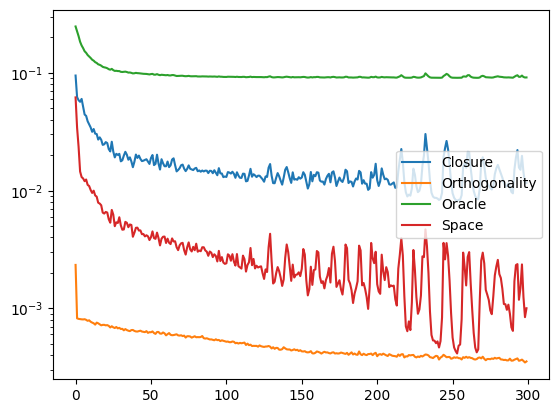

In [9]:
plt.plot(loss_S_closure, label =  "Closure")
plt.plot(loss_S_orth, label =  "Orthogonality")
plt.plot(loss_oracle, label =  "Oracle")
plt.plot(loss_space, label =  "Space")
plt.yscale("log")
plt.legend()

In [10]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


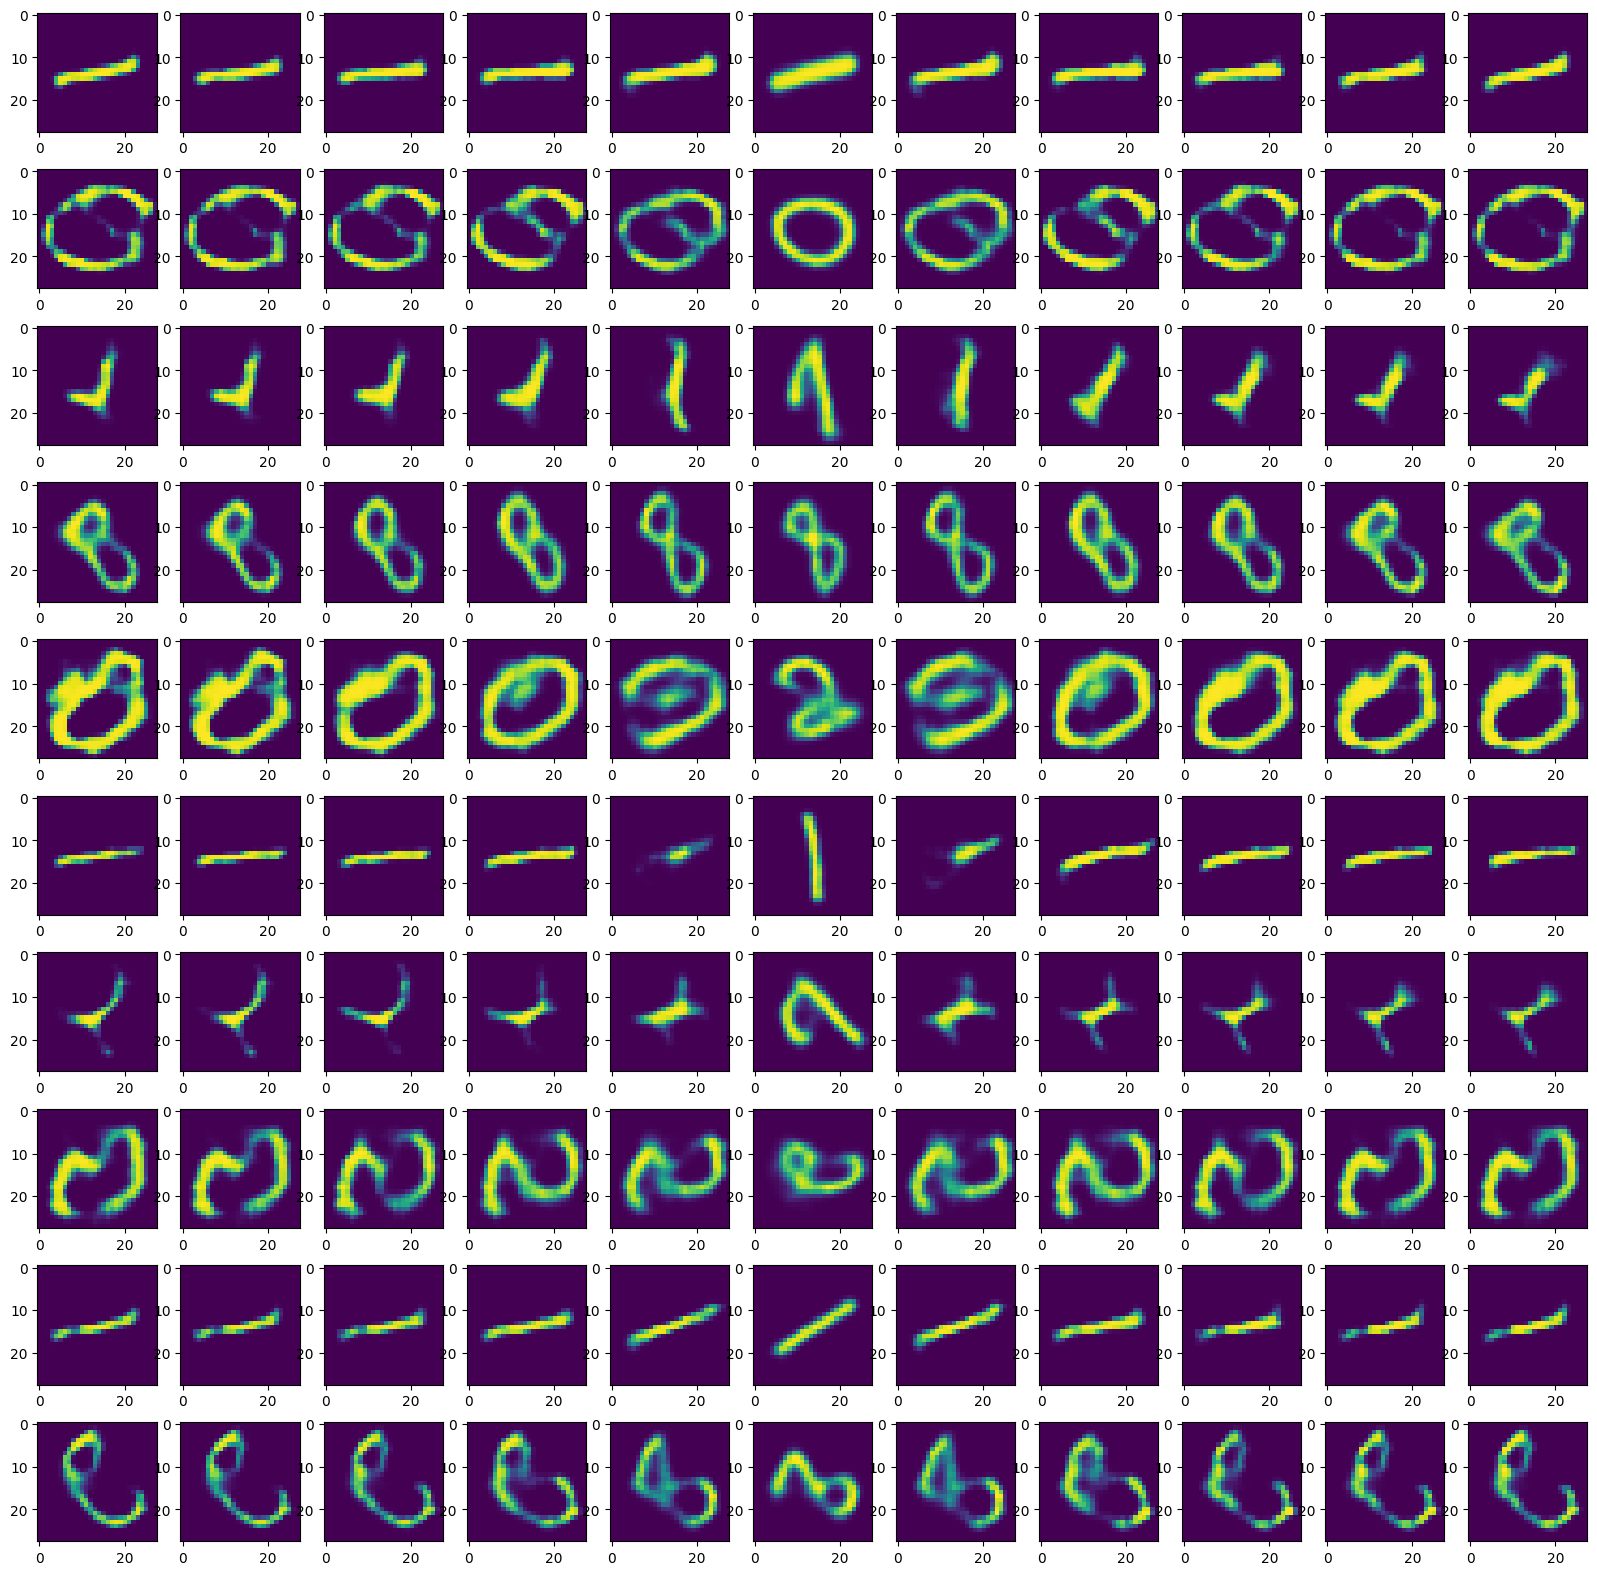

In [11]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

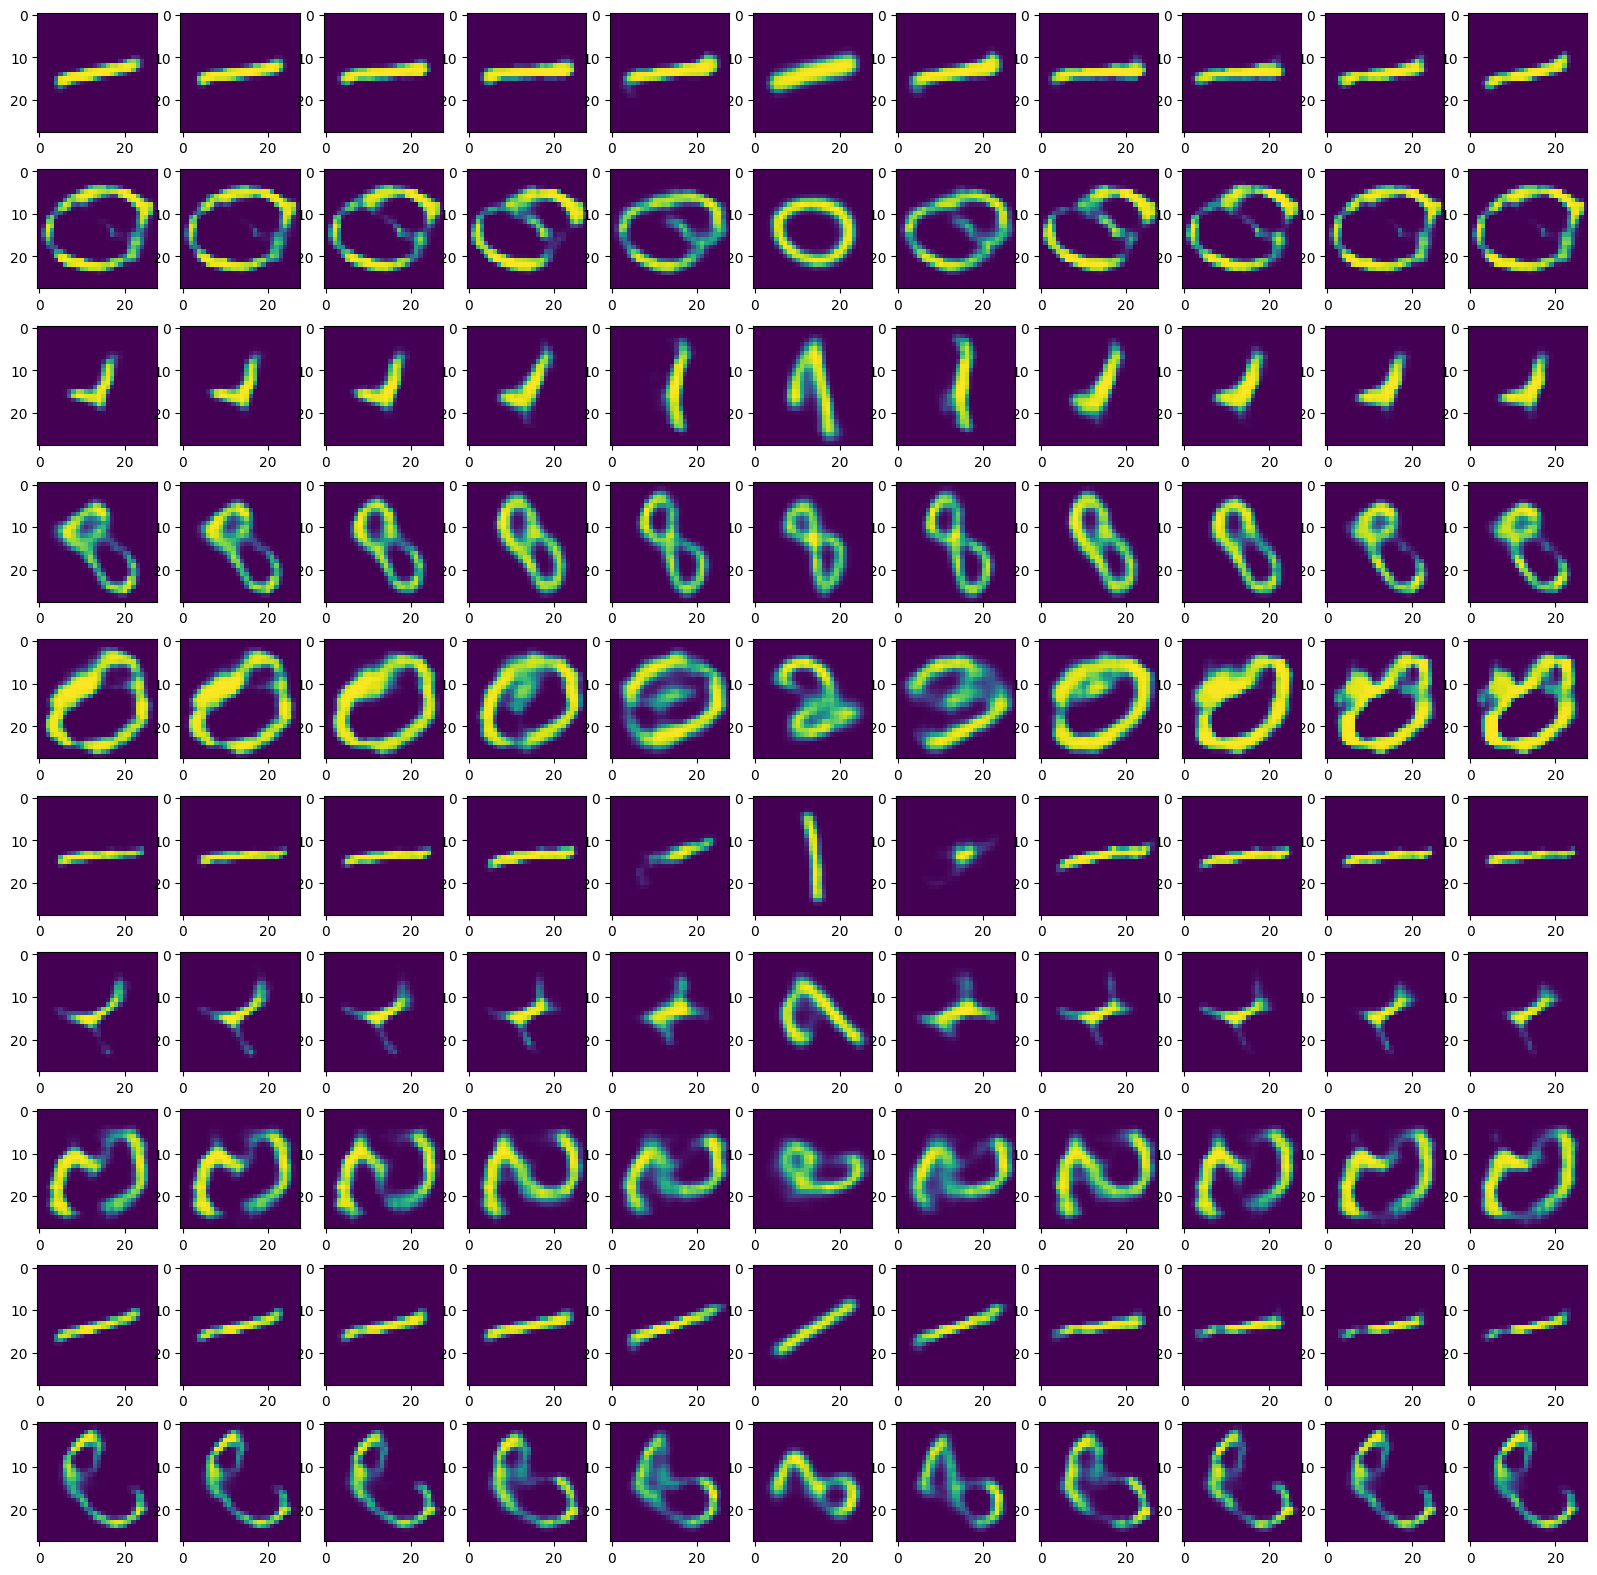

In [12]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

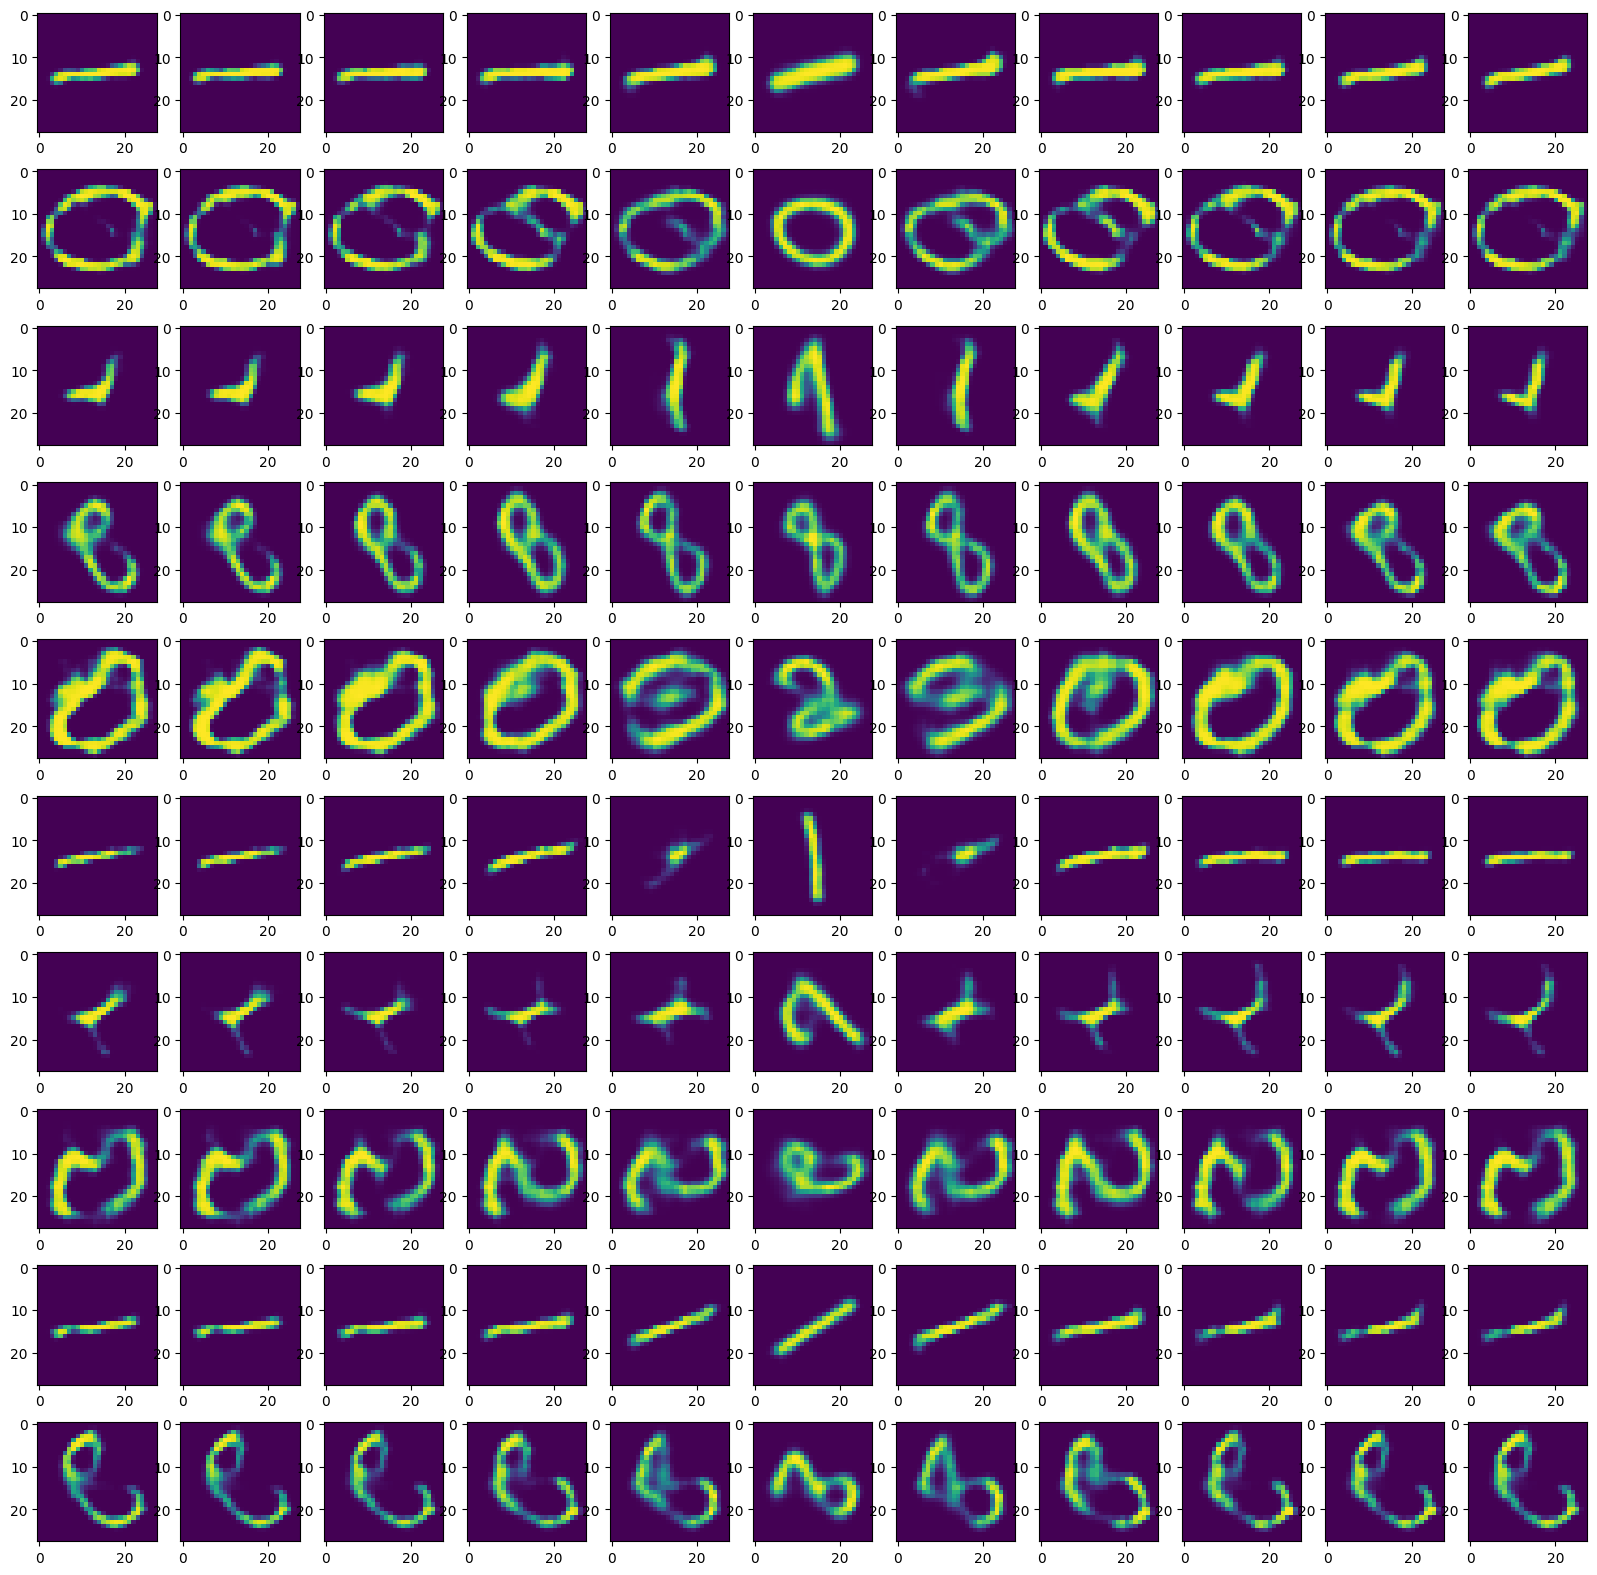

In [13]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step)],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

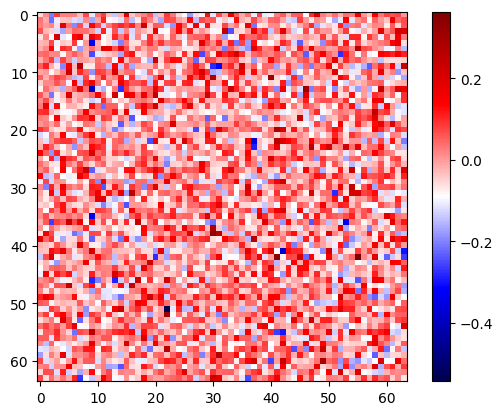

In [48]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

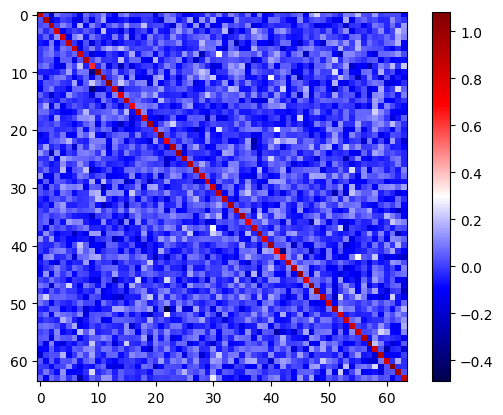

In [49]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

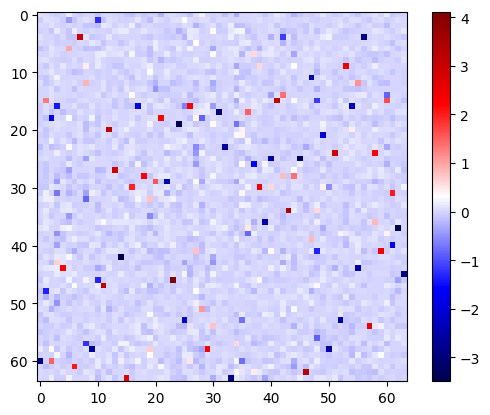

In [20]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

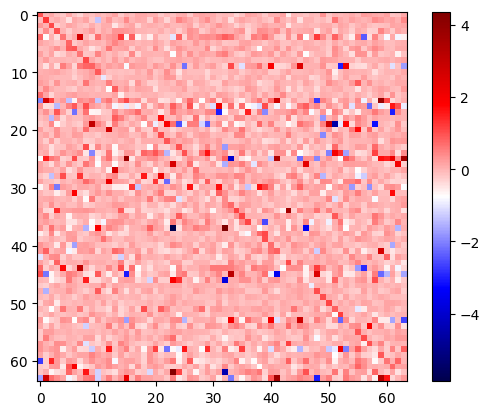

In [21]:
plt.imshow(torch.matrix_exp(model_symmetry.group[1].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

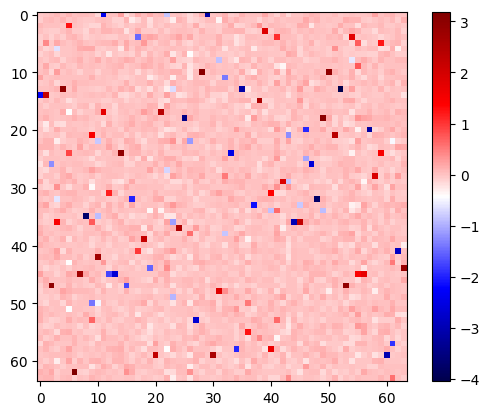

In [22]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

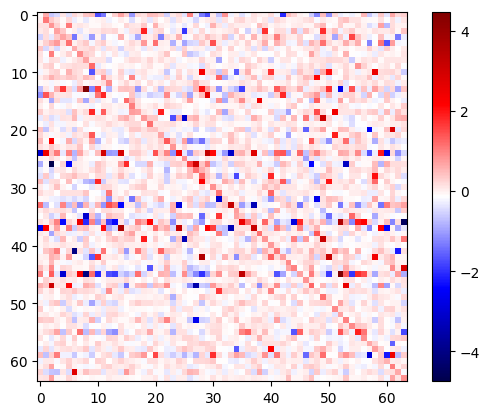

In [23]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()